
# 导入包

In [1]:
#  基础数据科学运算库
import pandas as pd
import numpy as np
import math
from scipy import stats

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt
# 排列组合函数
from itertools import product 
# 时间模块
import time
# sklearn库
# 数据预处理
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate,cross_val_score,KFold,LeaveOneOut
from sklearn import metrics
# 常用评估器
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# 常用的特征选择方法
import pymrmr
from minepy import MINE
import shap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import dcor

#忽略警告
import warnings
warnings.filterwarnings('ignore')


D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 导入数据

In [2]:
data_lmas=pd.read_csv('total_data.csv')# github上数据为：LMAs.csv
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]

# 定义函数

## 分层抽样函数

In [3]:
def stratifed_sample_cut(df,Y_columns,features,groups,train_split_ratio,random_state=None):
    """df:数据集
    Y_columns：目标变量
    features:特征集合
    groups：拆分组数
    train_split_ratio：训练集合百分比
    返回标准化后的X_train X_test y_train y_test
    """
    df_train = pd.DataFrame()
    ratio = train_split_ratio
    groups_list = [f'G{i}' for i in range(1,groups+1)] # G1 G2 ……
    df['groups'] = pd.cut(df[Y_columns], groups, labels=groups_list)
    for i in groups_list:
        df_group = df[df.groups == i] # 其中一个Group
        count = len(df_group)
        train_number  = round(count*ratio)
        print(train_number)
        df_train = df_train.append(df_group.sample(train_number,random_state=random_state))#  pandas.DataFrame.sample 随机选取若干行
       
    # test index 
    df_test_index = list(set(df.index)-set(df_train.index))
    # test_df 
    df_test = df[df.index.isin(df_test_index)]
    X_train = df_train[features]
    y_train = df_train[Y_columns].values.astype(float)
    X_test = df_test[features]
    y_test = df_test[Y_columns].values.astype(float)
    
    #标准化
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)
    return X_train,X_test,y_train,y_test

## 定义阈值

In [4]:
# 结果四舍五入  round
FN=len(X.columns)# 特征总数
def geometric_mean(data):  # 计算几何平均数
    total=1
    for i in data:
        total*=i #等同于total=total*i
    return round(pow(total,1/len(data)))

thr_geo=geometric_mean([*range(1,FN+1)])# 几何平均值 1,2……，n

def thr_log2n(data):
    thr_logn=round(math.log(data,2))#四舍五入
    return thr_logn
thr_logn=thr_log2n(FN)

thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]

print(thresholds)


[9, 4, 6, 11]


## 计算最大信息系数

In [13]:
# 小数位数 4→6
def mic_xy(X_train,y_train):# 计算特征与目标变量的最大信息系数，未排序 特征 mic得分一一对应
    MIC_score=[]
    for i in X_train.columns:
        x_=X_train[i]
        mine = MINE(alpha=0.6, c=15)
        mine.compute_score(x_, y_train)
        mic = np.around(mine.mic(),6)# 保留六位小数
        MIC_score.append(mic)
    MIC_score= pd.DataFrame(list(zip(X_train.columns,MIC_score)),columns=['Feature_MIC','Score_MIC'])
    return MIC_score

# total train test 分布可视化

8
5
9
10
6
2
5


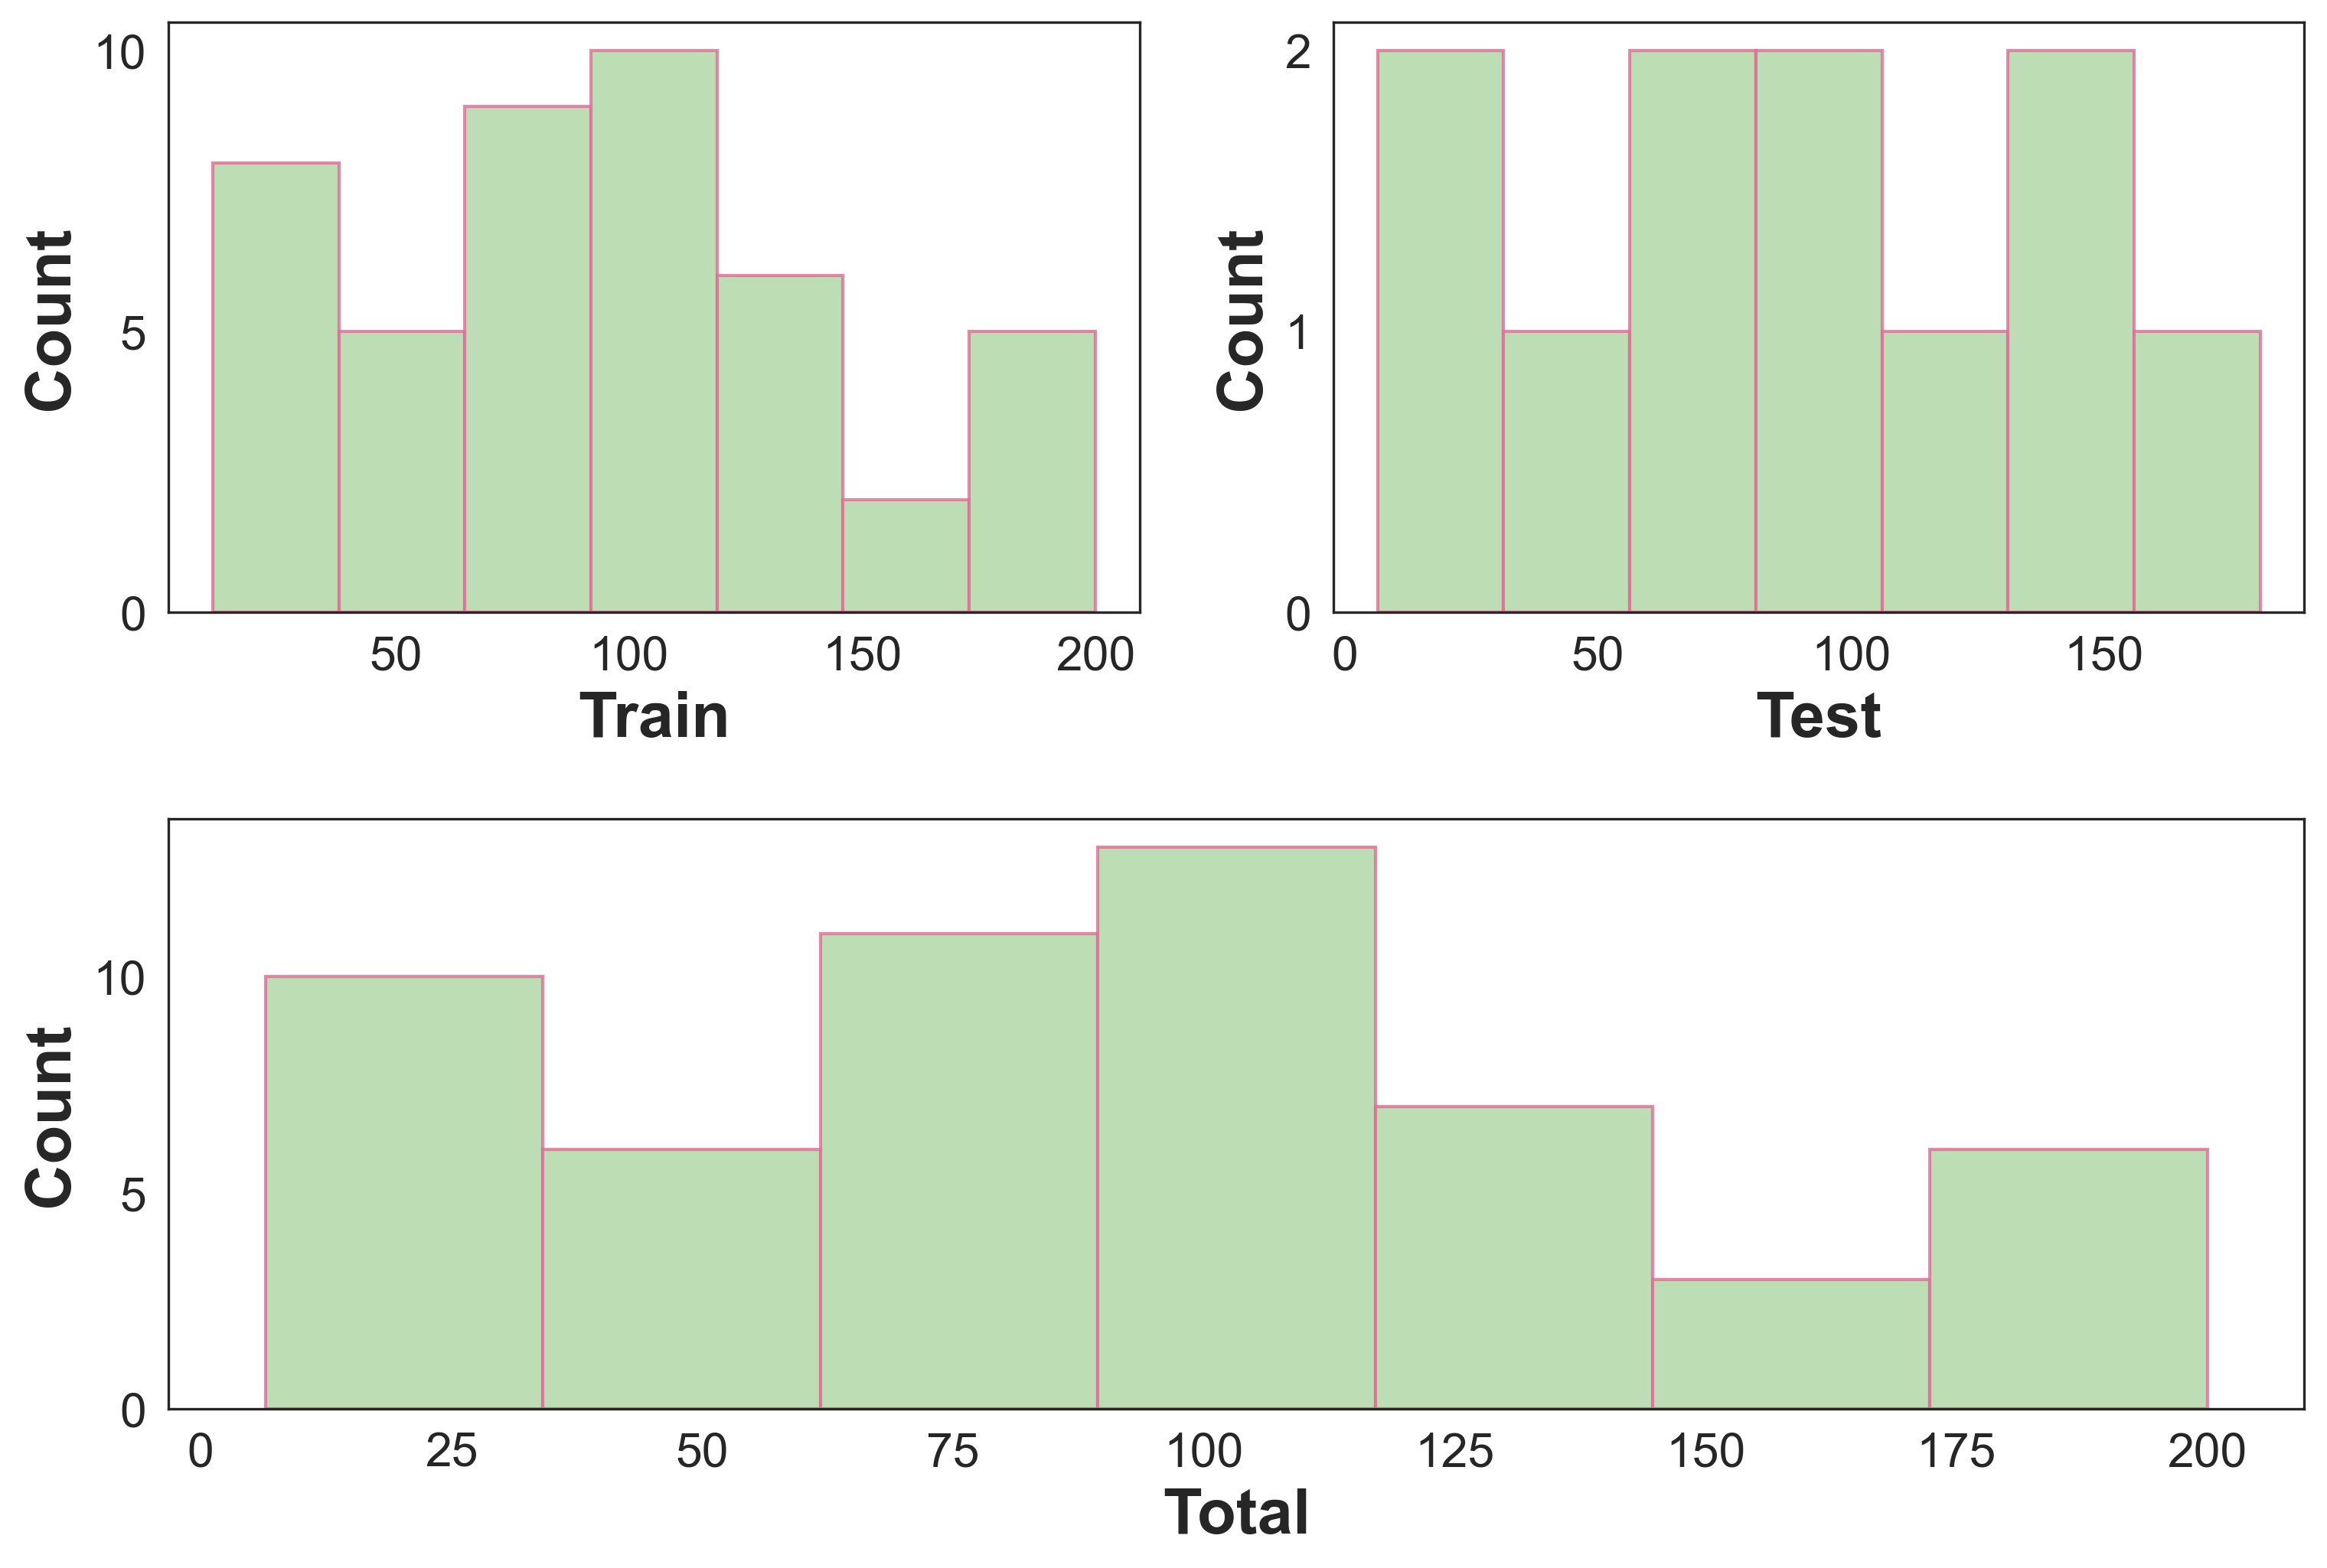

In [48]:
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]
num_bins = round(1 + np.log2(data_lmas.shape[0]))# 向下取整修改为四舍五入
features=data_lmas.columns[1:]
target=data_lmas.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_lmas,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)

plt.subplot(2,1,2)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Total',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小


plt.subplot(2,2,1)
plt.hist(y_train,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Train',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

plt.subplot(2,2,2)
plt.hist(y_test,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Test',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

8
5
9
10
6
2
5


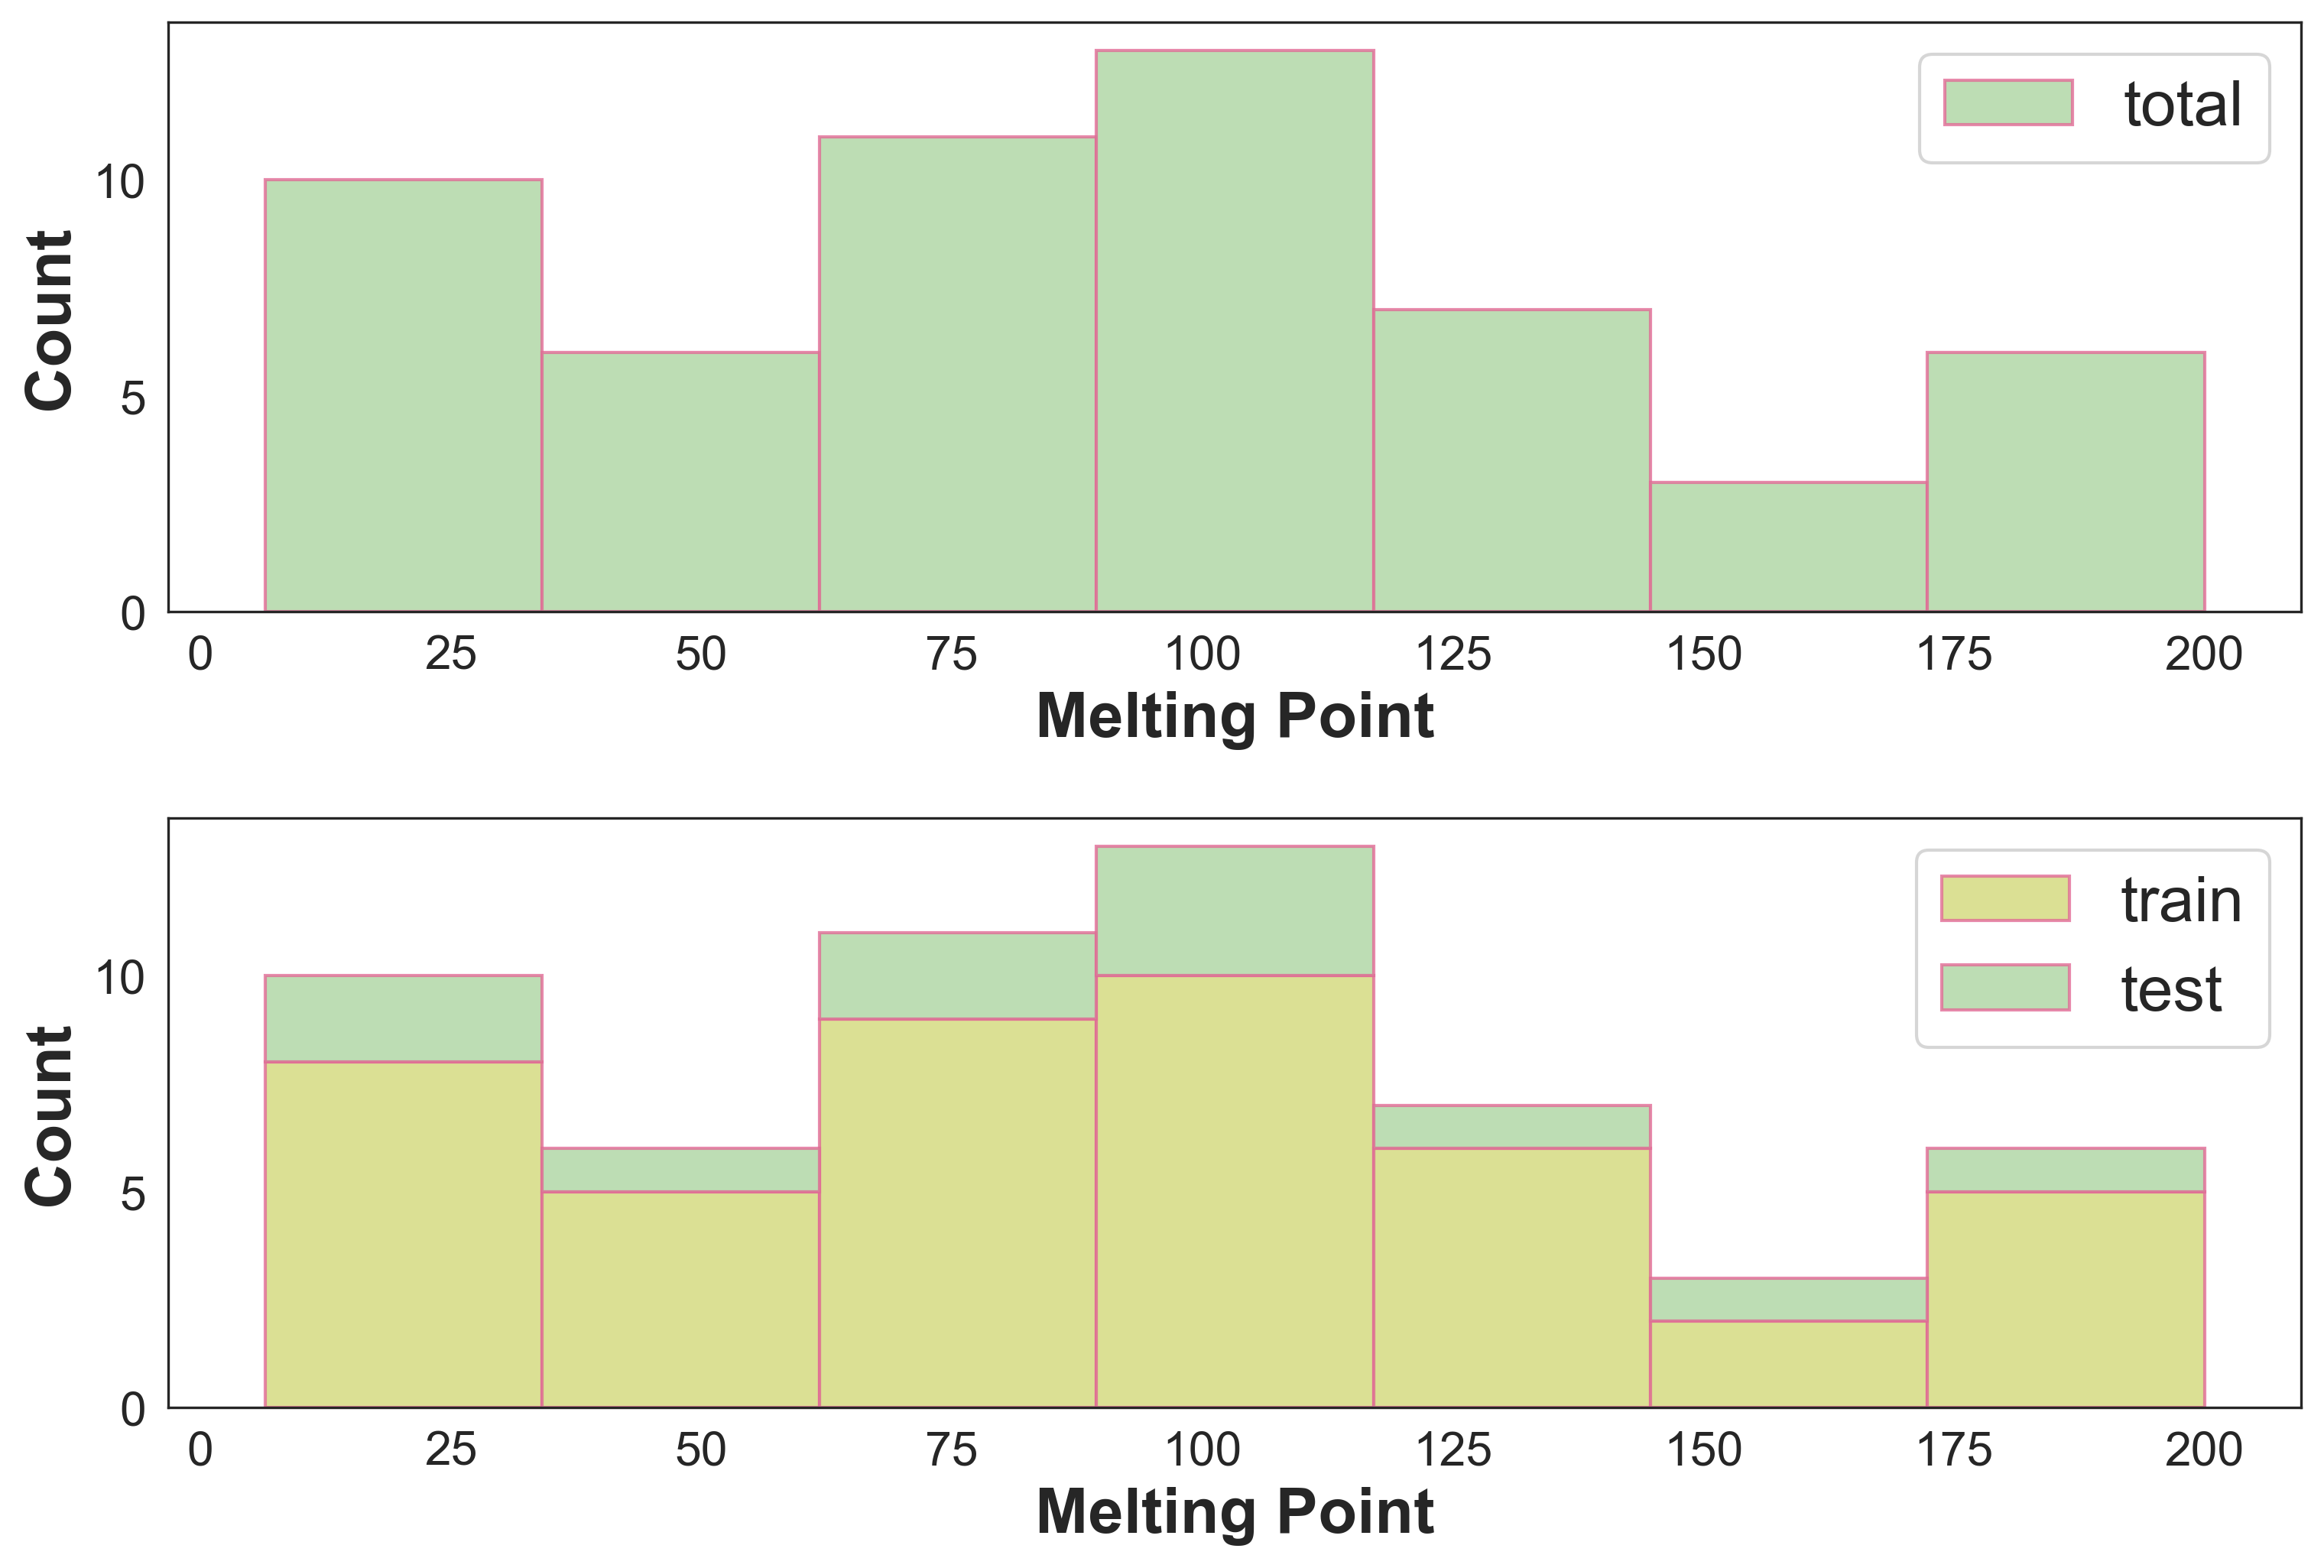

In [50]:
# 堆叠直方图
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]
num_bins = round(1 + np.log2(data_lmas.shape[0]))# 修改了
features=data_lmas.columns[1:]
target=data_lmas.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_lmas,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)
plt.subplot(2,1,1)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8,label='total')# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Melting Point',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='upper right') 

plt.subplot(2,1,2)
plt.hist([y_train,y_test],bins=num_bins,edgecolor="#e16c96",color=["#d2d97a","#add5a2"],alpha=0.8,stacked=True,label=["train","test"])
plt.xlabel('Melting Point',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.rcParams.update({'font.size': 20})    
plt.legend(loc='upper right') 


# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)



# MIC—SHAP

In [6]:
# random_state=0
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]

num_bins = round(1 + np.log2(data_lmas.shape[0]))# 最优箱数四舍五入
features=data_lmas.columns[1:]
target=data_lmas.columns[0]
X_train,X_test,y_train,y_test = stratifed_sample_cut(data_lmas,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

8
5
9
10
6
2
5


## 计算SHAP values¶

In [53]:
#SVR MLP默认参数改一下
# KNeighborsRegressor() 默认时报错   'NoneType' object has no attribute 'split'
models=[LinearRegression(),Ridge(),KNeighborsRegressor(algorithm='kd_tree'),SVR(C=40),MLPRegressor(hidden_layer_sizes=(100,80,60),random_state=0),XGBRegressor(random_state=0),RandomForestRegressor(random_state=0),CatBoostRegressor(verbose=False,random_state=0)]
modelname=['Linear','Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
import shap
score_shap_model_cut_0=pd.DataFrame([])
MIC_score=mic_xy(X_train,y_train)
for name,model in zip(modelname,models):
    print("="*60)
    print(name)
    model=model   #建立模型
    model.fit(X_train,y_train)
    explainer = shap.explainers.Permutation(model.predict, X_train)
    shap_values = explainer(X_train)
    #shap.summary_plot(shap_values, x, plot_type="bar",color='green')
    SHAP_score=pd.DataFrame(shap_values.values).apply(lambda x:abs(x)).mean()
    SHAP_score=round(pd.DataFrame(SHAP_score),6)
    score_shap_model_cut_0[name]=SHAP_score
score_shap_model_cut_0

Linear
Ridge
KNN
SVR


Permutation explainer: 46it [00:33,  1.68s/it]                                                                         


MLP


Permutation explainer: 46it [00:14,  1.08it/s]                                                                         


XGBoost


Permutation explainer: 46it [00:20,  1.08it/s]                                                                         


RF


Permutation explainer: 46it [00:34,  1.07it/s]                                                                         


CatBoost


Permutation explainer: 46it [00:13,  1.00it/s]                                                                         


,Linear,Ridge,KNN,SVR,MLP,XGBoost,RF,CatBoost
0,2.978594e+09,11.029991,4.917599,5.641197,11.918280,26.369326,27.802671,13.876232
1,2.139108e+09,4.086982,1.883660,1.300498,3.158759,1.211480,0.364771,1.917218
2,8.954418e+09,3.880465,2.666263,2.259012,5.086722,5.267881,1.418289,1.924063
3,4.886094e+09,2.042672,3.045173,0.864791,3.271634,0.894847,0.040968,0.497117
4,2.552383e+09,1.872215,2.938152,1.951077,4.796731,0.626991,0.268397,0.871600
5,3.990800e+09,8.298595,4.084353,3.858108,6.372406,6.897800,2.458684,0.755630
6,2.129431e+09,1.267443,1.372845,0.449678,0.600884,0.123746,0.098233,0.114775
7,5.834316e+08,1.069782,0.317274,0.997345,1.085549,0.454010,0.010225,0.051107
8,2.255934e+00,0.689970,1.974351,2.373619,1.418932,4.534793,1.364096,1.061644
9,8.196462e+09,1.049339,1.274786,1.355540,1.862307,0.996379,0.181416,1.262742


In [54]:
score_shap_model_cut_0['MIC']=MIC_score['Score_MIC']
score_shap_model_cut_0=pd.DataFrame(MinMaxScaler().fit_transform(score_shap_model_cut_0),columns=modelname+['MIC'])
score_shap_model_cut_0.to_csv('20221025score_shap_model_cut_0.csv')

In [10]:
score_shap_model_cut_0=pd.read_csv('20221025score_shap_model_cut_0.csv')

In [56]:
#阈值
FN=len(X_train.columns)
thr_geo=geometric_mean([*range(1,FN+1)])
thr_logn=thr_log2n(FN)
thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[9, 4, 6, 11]

## 定义不同阈值下权重优化函数

### 几何平均值

In [68]:
# 几何平均值
thr=thr_geo
thr_name='thr_geo'
print(thr)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo

9
Linear
test_r2: [0.934996, 0.934996, 0.886489, 0.885649, 0.885649, 0.857426, 0.837342, 0.829242, 0.836614, 0.836614, 0.836614]
test_r:  [0.973265, 0.973265, 0.942054, 0.941625, 0.941625, 0.929857, 0.925038, 0.916867, 0.923548, 0.923548, 0.923548]
test_rmse:  [13.207327, 13.207327, 17.45281, 17.517245, 17.517245, 19.559886, 20.892187, 21.406032, 20.93885, 20.938851, 20.938849]
0.934996 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [-0.093712, -0.093712, -0.093776, -0.093776, -0.093776, -0.093776, -0.093776, 0.093776, -0.093776, -0.093776, -0.093776]
cv5_r2 :  [-237247604.346672, -237233068.781343, -9858057511321.75, -2849736576925.8154, -2849737101985.8276, -5524914369168.573, -11887457217199.268, -64039950351361.586, -525024434548883.25, -525024463757393.3, -525024306300694.3]
-237233068.781343 1
a_best_cv5 = 0.1
b_best_cv5= 0.9
features_cv5= ['f0', 'f5', 'f12', 'f11', 'f20', 'f2', 'f17', 'f18', 'f21']
cv10_r :  [0.09388, 0.09388, -0.093776, -0.093776, -0.093776, -0.093776, -0.093776

test_r2: [0.709754, 0.709754, 0.696227, 0.696227, 0.683884, 0.695715, 0.695715, 0.671872, 0.690956, 0.660947, 0.673131]
test_r:  [0.861708, 0.861708, 0.851462, 0.851462, 0.848291, 0.852524, 0.852524, 0.841422, 0.852936, 0.845502, 0.856146]
test_rmse:  [27.908036, 27.908036, 28.550939, 28.550939, 29.125227, 28.574984, 28.574984, 29.673409, 28.797595, 30.16337, 29.61643]
0.709754 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.961783, 0.961783, 0.960157, 0.960157, 0.950007, 0.948331, 0.948331, 0.945479, 0.963948, 0.947948, 0.945209]
cv5_r2 :  [0.92398, 0.92398, 0.921046, 0.921046, 0.901384, 0.897884, 0.897884, 0.892954, 0.927978, 0.897359, 0.891864]
0.927978 8
a_best_cv5 = 0.8
b_best_cv5= 0.19999999999999996
features_cv5= ['f0', 'f11', 'f17', 'f12', 'f20', 'f15', 'f2', 'f18', 'f21']
cv10_r :  [0.966568, 0.966568, 0.96602, 0.96602, 0.955783, 0.953094, 0.953094, 0.953422, 0.961653, 0.954409, 0.962432]
cv10_r2 :  [0.933137, 0.933137, 0.932621, 0.932621, 0.912947, 0.907677, 0.907677, 0.9086

(          FN=9  Linearthr_name_cv5  Ridgethr_name_cv5  KNNthr_name_cv5  \
 0   a_best_cv5        1.000000e-01           0.600000         0.500000   
 1   cv5_r_best       -9.371200e-02           0.973455         0.949343   
 2  cv5_r2_best       -2.372331e+08           0.947347         0.900610   
 3   test_r_cv5        9.732650e-01           0.966718         0.796538   
 4  test_r2_cv5        9.349960e-01           0.929957         0.588362   
 
    SVRthr_name_cv5  MLPthr_name_cv5  XGBoostthr_name_cv5  RFthr_name_cv5  \
 0         0.400000         0.800000             0.200000        0.700000   
 1         0.973574         0.973656             0.954310        0.952738   
 2         0.937905         0.947066             0.909660        0.907452   
 3         0.864113         0.916125             0.865920        0.773984   
 4         0.716018         0.810467             0.735909        0.561257   
 
    CatBoostthr_name_cv5  
 0              0.800000  
 1              0.963948  
 2 

In [69]:
cv5_score_sum_geo

,FN=9,Linearthr_name_cv5,Ridgethr_name_cv5,KNNthr_name_cv5,SVRthr_name_cv5,MLPthr_name_cv5,XGBoostthr_name_cv5,RFthr_name_cv5,CatBoostthr_name_cv5
0,a_best_cv5,1.000000e-01,0.600000,0.500000,0.400000,0.800000,0.200000,0.700000,0.800000
1,cv5_r_best,-9.371200e-02,0.973455,0.949343,0.973574,0.973656,0.954310,0.952738,0.963948
2,cv5_r2_best,-2.372331e+08,0.947347,0.900610,0.937905,0.947066,0.909660,0.907452,0.927978
3,test_r_cv5,9.732650e-01,0.966718,0.796538,0.864113,0.916125,0.865920,0.773984,0.852936
4,test_r2_cv5,9.349960e-01,0.929957,0.588362,0.716018,0.810467,0.735909,0.561257,0.690956


In [70]:
cv5_score_sum_geo.to_csv('20221025cv5_score_sum_geo.csv')

In [71]:
cv10_score_sum_geo

,FN=9,Linearthr_name_cv10,Ridgethr_name_cv10,KNNthr_name_cv10,SVRthr_name_cv10,MLPthr_name_cv10,XGBoostthr_name_cv10,RFthr_name_cv10,CatBoostthr_name_cv10
0,a_best_cv10,0.000000e+00,0.200000,0.500000,0.400000,0.800000,0.200000,0.400000,0.000000
1,cv10_r_best,9.388000e-02,0.978138,0.959327,0.977429,0.966453,0.954706,0.953470,0.966568
2,cv10_r2_best,-9.005151e+07,0.956594,0.917703,0.945136,0.931639,0.909787,0.908755,0.933137
3,test_r_cv10,9.732650e-01,0.969974,0.796538,0.864113,0.916125,0.865920,0.782739,0.861708
4,test_r2_cv10,9.349960e-01,0.936640,0.588362,0.716018,0.810467,0.735909,0.574224,0.709754


In [72]:
cv10_score_sum_geo.to_csv('20221025cv10_score_sum_geo.csv')

In [73]:
test_score_sum_geo

,FN=9,Linearthr_name_test,Ridgethr_name_test,KNNthr_name_test,SVRthr_name_test,MLPthr_name_test,XGBoostthr_name_test,RFthr_name_test,CatBoostthr_name_test
0,a_best_test,0.000000e+00,0.000000,0.900000,0.800000,0.000000,0.400000,0.100000,0.000000
1,cv5_r_t,-9.371200e-02,0.971040,0.946624,0.968928,0.961523,0.940995,0.950959,0.961783
2,cv5_r2_t,-2.372476e+08,0.942441,0.889216,0.931914,0.922783,0.882847,0.903875,0.923980
3,cv10_r_t,9.388000e-02,0.976821,0.949422,0.971702,0.964885,0.942076,0.950015,0.966568
4,cv10_r2_t,-9.005151e+07,0.954014,0.892944,0.936257,0.930203,0.883928,0.902298,0.933137
5,test_r_best,9.732650e-01,0.971640,0.934456,0.884502,0.951906,0.876411,0.796562,0.861708
6,test_r2_best,9.349960e-01,0.938568,0.827591,0.756862,0.898333,0.736918,0.596668,0.709754


In [74]:
test_score_sum_geo.to_csv('20221025test_score_sum_geo.csv')

### log2n

In [75]:
thr=thr_logn
thr_name='thr_logn'
print(thr)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn

4
Linear
test_r2: [0.606416, 0.606416, 0.695753, 0.466568, 0.466568, 0.663491, 0.663491, 0.663491, 0.663491, 0.663491, 0.253027]
test_r:  [0.787217, 0.787217, 0.846779, 0.691596, 0.691596, 0.829116, 0.829116, 0.829116, 0.829116, 0.829116, 0.510814]
test_rmse:  [32.498595, 32.498595, 28.573213, 37.834266, 37.834266, 30.049989, 30.049989, 30.049989, 30.049989, 30.049989, 44.771142]
0.695753 2
test_a_best = 0.2
test_b_best= 0.8
cv5_r :  [0.900861, 0.900861, 0.901161, 0.895042, 0.895042, 0.925592, 0.925592, 0.925592, 0.925592, 0.925592, 0.704744]
cv5_r2 :  [0.806163, 0.806163, 0.80873, 0.796698, 0.796698, 0.854775, 0.854775, 0.854775, 0.854775, 0.854775, 0.494539]
0.854775 5
a_best_cv5 = 0.5
b_best_cv5= 0.5
features_cv5= ['f14', 'f2', 'f9', 'f5']
cv10_r :  [0.915012, 0.915012, 0.914264, 0.909273, 0.909273, 0.929949, 0.929949, 0.929949, 0.929949, 0.929949, 0.672838]
cv10_r2 :  [0.83665, 0.83665, 0.835678, 0.826292, 0.826292, 0.86453, 0.86453, 0.86453, 0.86453, 0.86453, 0.444776]
0.86453 5
a

test_r2: [0.624515, 0.633719, 0.629903, 0.585531, 0.585531, 0.56893, 0.56893, 0.56893, 0.56893, 0.587184, 0.587184]
test_r:  [0.82696, 0.826418, 0.822149, 0.814322, 0.814322, 0.802907, 0.802907, 0.802907, 0.802907, 0.802124, 0.802124]
test_rmse:  [31.742573, 31.351106, 31.514025, 33.349678, 33.349678, 34.011014, 34.011014, 34.011014, 34.011014, 33.283109, 33.283109]
0.633719 1
test_a_best = 0.1
test_b_best= 0.9
cv5_r :  [0.949911, 0.946025, 0.946333, 0.94245, 0.94245, 0.946634, 0.946634, 0.946634, 0.946634, 0.927596, 0.927596]
cv5_r2 :  [0.902235, 0.894959, 0.895528, 0.88803, 0.88803, 0.895958, 0.895958, 0.895958, 0.895958, 0.860415, 0.860415]
0.902235 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['f0', 'f12', 'f5', 'f11']
cv10_r :  [0.95082, 0.949325, 0.952044, 0.94617, 0.94617, 0.950131, 0.950131, 0.950131, 0.950131, 0.927126, 0.927126]
cv10_r2 :  [0.903785, 0.90072, 0.906241, 0.895209, 0.895209, 0.902365, 0.902365, 0.902365, 0.902365, 0.859456, 0.859456]
0.906241 2
a_best_cv10 =

(          FN=4  Linearthr_name_cv5  Ridgethr_name_cv5  KNNthr_name_cv5  \
 0   a_best_cv5            0.500000           0.400000         0.000000   
 1   cv5_r_best            0.925592           0.913227         0.943671   
 2  cv5_r2_best            0.854775           0.832486         0.887933   
 3   test_r_cv5            0.829116           0.829288         0.756706   
 4  test_r2_cv5            0.663491           0.667085         0.522277   
 
    SVRthr_name_cv5  MLPthr_name_cv5  XGBoostthr_name_cv5  RFthr_name_cv5  \
 0         0.000000         0.000000             0.500000        0.300000   
 1         0.953317         0.965153             0.944291        0.958339   
 2         0.905661         0.926808             0.885299        0.918308   
 3         0.748871         0.854695             0.741450        0.783346   
 4         0.507315         0.682479             0.502735        0.557903   
 
    CatBoostthr_name_cv5  
 0              0.000000  
 1              0.949911  
 2 

In [81]:
cv5_score_sum_logn

,FN=4,Linearthr_name_cv5,Ridgethr_name_cv5,KNNthr_name_cv5,SVRthr_name_cv5,MLPthr_name_cv5,XGBoostthr_name_cv5,RFthr_name_cv5,CatBoostthr_name_cv5
0,a_best_cv5,0.500000,0.400000,0.000000,0.000000,0.000000,0.500000,0.300000,0.000000
1,cv5_r_best,0.925592,0.913227,0.943671,0.953317,0.965153,0.944291,0.958339,0.949911
2,cv5_r2_best,0.854775,0.832486,0.887933,0.905661,0.926808,0.885299,0.918308,0.902235
3,test_r_cv5,0.829116,0.829288,0.756706,0.748871,0.854695,0.741450,0.783346,0.826960
4,test_r2_cv5,0.663491,0.667085,0.522277,0.507315,0.682479,0.502735,0.557903,0.624515


In [82]:
cv5_score_sum_logn.to_csv('20221025cv5_score_sum_logn.csv')

In [83]:
cv10_score_sum_logn

,FN=4,Linearthr_name_cv10,Ridgethr_name_cv10,KNNthr_name_cv10,SVRthr_name_cv10,MLPthr_name_cv10,XGBoostthr_name_cv10,RFthr_name_cv10,CatBoostthr_name_cv10
0,a_best_cv10,0.500000,0.400000,0.000000,0.000000,0.000000,0.200000,0.300000,0.200000
1,cv10_r_best,0.929949,0.922805,0.953534,0.963410,0.965294,0.950947,0.952919,0.952044
2,cv10_r2_best,0.864530,0.851530,0.907617,0.925669,0.930011,0.901713,0.907760,0.906241
3,test_r_cv10,0.829116,0.829288,0.756706,0.748871,0.854695,0.796531,0.783346,0.822149
4,test_r2_cv10,0.663491,0.667085,0.522277,0.507315,0.682479,0.579625,0.557903,0.629903


In [84]:
cv10_score_sum_logn.to_csv('20221025cv10_score_sum_logn.csv')

In [85]:
test_score_sum_logn

,FN=4,Linearthr_name_test,Ridgethr_name_test,KNNthr_name_test,SVRthr_name_test,MLPthr_name_test,XGBoostthr_name_test,RFthr_name_test,CatBoostthr_name_test
0,a_best_test,0.200000,0.400000,0.000000,0.400000,0.700000,0.000000,0.300000,0.100000
1,cv5_r_t,0.901161,0.913227,0.943671,0.924591,0.933767,0.939563,0.958339,0.946025
2,cv5_r2_t,0.808730,0.832486,0.887933,0.854805,0.826234,0.878315,0.918308,0.894959
3,cv10_r_t,0.914264,0.922805,0.953534,0.940749,0.937690,0.948557,0.952919,0.949325
4,cv10_r2_t,0.835678,0.851530,0.907617,0.883990,0.835119,0.897333,0.907760,0.900720
5,test_r_best,0.846779,0.829288,0.756706,0.759222,0.892194,0.808003,0.783346,0.826418
6,test_r2_best,0.695753,0.667085,0.522277,0.552344,0.761348,0.604389,0.557903,0.633719


In [86]:
test_score_sum_logn.to_csv('20221025test_score_sum_logn.scv')

### 25%

In [87]:
thr=thr_25
thr_name='thr_25'
print(thr)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25

6
Linear
test_r2: [0.702277, 0.845227, 0.845227, 0.821989, 0.797382, 0.797382, 0.797382, 0.835225, 0.835225, 0.835225, 0.835225]
test_r:  [0.853548, 0.929033, 0.929033, 0.920518, 0.903763, 0.903763, 0.903763, 0.919506, 0.919506, 0.919506, 0.919506]
test_rmse:  [28.265206, 20.379528, 20.379528, 21.855919, 23.317657, 23.317657, 23.317657, 21.027685, 21.027685, 21.027685, 21.027685]
0.845227 1
test_a_best = 0.1
test_b_best= 0.9
cv5_r :  [0.903707, 0.909092, 0.909092, 0.895119, 0.925284, 0.925284, 0.925284, 0.923086, 0.923086, 0.923086, 0.923086]
cv5_r2 :  [0.809944, 0.821404, 0.821404, 0.793534, 0.852293, 0.852293, 0.852293, 0.847708, 0.847708, 0.847708, 0.847708]
0.852293 4
a_best_cv5 = 0.4
b_best_cv5= 0.6
features_cv5= ['f2', 'f14', 'f5', 'f0', 'f9', 'f12']
cv10_r :  [0.913047, 0.922995, 0.922995, 0.901029, 0.932967, 0.932967, 0.932967, 0.935204, 0.935204, 0.935204, 0.935204]
cv10_r2 :  [0.832414, 0.851739, 0.851739, 0.810299, 0.869749, 0.869749, 0.869749, 0.874426, 0.874426, 0.874426, 

test_r2: [0.700298, 0.693016, 0.663776, 0.674269, 0.678257, 0.668401, 0.664268, 0.664268, 0.664268, 0.680114, 0.677675]
test_r:  [0.860486, 0.855515, 0.839024, 0.846236, 0.851535, 0.845341, 0.841234, 0.841234, 0.841234, 0.854702, 0.85411]
test_rmse:  [28.358983, 28.701445, 30.037233, 29.564817, 29.383276, 29.829922, 30.015251, 30.015251, 30.015251, 29.298345, 29.409854]
0.700298 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.941096, 0.940791, 0.93916, 0.938276, 0.940899, 0.938798, 0.942983, 0.942983, 0.942983, 0.942726, 0.942576]
cv5_r2 :  [0.885431, 0.884916, 0.881643, 0.880124, 0.88512, 0.881189, 0.88851, 0.88851, 0.88851, 0.888506, 0.887847]
0.88851 6
a_best_cv5 = 0.6
b_best_cv5= 0.4
features_cv5= ['f0', 'f11', 'f17', 'f12', 'f20', 'f15']
cv10_r :  [0.948821, 0.951165, 0.951398, 0.952204, 0.95378, 0.950409, 0.948945, 0.948945, 0.948945, 0.953024, 0.95439]
cv10_r2 :  [0.90001, 0.904361, 0.905055, 0.906528, 0.90948, 0.902969, 0.900261, 0.900261, 0.900261, 0.907499, 0.910301]
0.91030

(          FN=6  Linearthr_name_cv5  Ridgethr_name_cv5  KNNthr_name_cv5  \
 0   a_best_cv5            0.400000           0.700000         0.000000   
 1   cv5_r_best            0.925284           0.973774         0.932753   
 2  cv5_r2_best            0.852293           0.948007         0.862578   
 3   test_r_cv5            0.903763           0.967111         0.758293   
 4  test_r2_cv5            0.797382           0.932724         0.514789   
 
    SVRthr_name_cv5  MLPthr_name_cv5  XGBoostthr_name_cv5  RFthr_name_cv5  \
 0         0.000000         0.000000             0.200000        0.800000   
 1         0.935888         0.942923             0.946451        0.946029   
 2         0.874413         0.881905             0.891331        0.894737   
 3         0.755680         0.809322             0.666427        0.790879   
 4         0.521792         0.644316             0.348295        0.575282   
 
    CatBoostthr_name_cv5  
 0              0.600000  
 1              0.942983  
 2 

In [88]:
cv5_score_sum_25

,FN=6,Linearthr_name_cv5,Ridgethr_name_cv5,KNNthr_name_cv5,SVRthr_name_cv5,MLPthr_name_cv5,XGBoostthr_name_cv5,RFthr_name_cv5,CatBoostthr_name_cv5
0,a_best_cv5,0.400000,0.700000,0.000000,0.000000,0.000000,0.200000,0.800000,0.600000
1,cv5_r_best,0.925284,0.973774,0.932753,0.935888,0.942923,0.946451,0.946029,0.942983
2,cv5_r2_best,0.852293,0.948007,0.862578,0.874413,0.881905,0.891331,0.894737,0.888510
3,test_r_cv5,0.903763,0.967111,0.758293,0.755680,0.809322,0.666427,0.790879,0.841234
4,test_r2_cv5,0.797382,0.932724,0.514789,0.521792,0.644316,0.348295,0.575282,0.664268


In [89]:
cv5_score_sum_25.to_csv('20221025cv5_score_sum_25.csv')

In [90]:
cv10_score_sum_25

,FN=6,Linearthr_name_cv10,Ridgethr_name_cv10,KNNthr_name_cv10,SVRthr_name_cv10,MLPthr_name_cv10,XGBoostthr_name_cv10,RFthr_name_cv10,CatBoostthr_name_cv10
0,a_best_cv10,0.700000,0.700000,0.000000,0.000000,0.100000,0.700000,1.000000,1.000000
1,cv10_r_best,0.935204,0.978599,0.944249,0.947647,0.942334,0.942328,0.949308,0.954390
2,cv10_r2_best,0.874426,0.957505,0.883148,0.895626,0.853067,0.881889,0.900986,0.910301
3,test_r_cv10,0.919506,0.967111,0.758293,0.755680,0.819488,0.881354,0.742926,0.854110
4,test_r2_cv10,0.835225,0.932724,0.514789,0.521792,0.665145,0.756561,0.494163,0.677675


In [91]:
cv10_score_sum_25.to_csv('20221025cv10_score_sum_25.csv')

In [92]:
test_score_sum_25

,FN=6,Linearthr_name_test,Ridgethr_name_test,KNNthr_name_test,SVRthr_name_test,MLPthr_name_test,XGBoostthr_name_test,RFthr_name_test,CatBoostthr_name_test
0,a_best_test,0.100000,0.700000,0.000000,0.600000,0.200000,0.700000,0.800000,0.000000
1,cv5_r_t,0.909092,0.973774,0.932753,0.931964,0.943630,0.942130,0.946029,0.941096
2,cv5_r2_t,0.821404,0.948007,0.862578,0.867207,0.854208,0.884589,0.894737,0.885431
3,cv10_r_t,0.922995,0.978599,0.944249,0.944332,0.943442,0.942328,0.944714,0.948821
4,cv10_r2_t,0.851739,0.957505,0.883148,0.888882,0.850918,0.881889,0.892170,0.900010
5,test_r_best,0.929033,0.967111,0.758293,0.772157,0.826439,0.881354,0.790879,0.860486
6,test_r2_best,0.845227,0.932724,0.514789,0.565995,0.676628,0.756561,0.575282,0.700298


In [93]:
test_score_sum_25.to_csv('20221025test_score_sum_25.csv')

### 50%

In [94]:
thr=thr_50
thr_name='thr_50'
print(thr)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50

11
Linear
test_r2: [0.949923, 0.9486, 0.930737, 0.909945, 0.909945, 0.909945, 0.909945, 0.83241, 0.817591, 0.817591, 0.821611]
test_r:  [0.978129, 0.9783, 0.973295, 0.954171, 0.954171, 0.954171, 0.954171, 0.922681, 0.915961, 0.915961, 0.915871]
test_rmse:  [11.592167, 11.744327, 13.633149, 15.545339, 15.545345, 15.54534, 15.545341, 21.206571, 22.124284, 22.124285, 21.879112]
0.949923 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.09383, -0.093743, 0.093782, -0.093776, -0.093776, -0.093776, -0.093776, -0.093775, -0.093776, -0.093776, -0.093776]
cv5_r2 :  [-336163964.547824, -877935898.867588, -31401188268.48838, -34968792100227.547, -34968801831592.332, -34968815124768.656, -34968805338097.31, -324638693747.19, -343230838126926.5, -343230992301716.7, -171211366371505.78]
-336163964.547824 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['f0', 'f12', 'f5', 'f11', 'f20', 'f17', 'f18', 'f21', 'f2', 'f16', 'f13']
cv10_r :  [-0.093724, 0.093791, 0.093779, -0.093776, -0.093776, -0.093776, 

test_r2: [0.698425, 0.720306, 0.706915, 0.706915, 0.707617, 0.744794, 0.744794, 0.705345, 0.70972, 0.728924, 0.744754]
test_r:  [0.854782, 0.86724, 0.857643, 0.857643, 0.855739, 0.881955, 0.881955, 0.8608, 0.866936, 0.882068, 0.887248]
test_rmse:  [28.447437, 27.396013, 28.044181, 28.044181, 28.010564, 26.169267, 26.169267, 28.119191, 27.909647, 26.970667, 26.171301]
0.744794 5
test_a_best = 0.5
test_b_best= 0.5
cv5_r :  [0.966354, 0.963992, 0.96255, 0.96255, 0.961289, 0.96389, 0.96389, 0.961323, 0.960535, 0.959718, 0.958413]
cv5_r2 :  [0.931909, 0.926945, 0.92546, 0.92546, 0.922468, 0.927647, 0.927647, 0.922437, 0.920971, 0.919409, 0.915979]
0.931909 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['f0', 'f12', 'f5', 'f11', 'f20', 'f17', 'f18', 'f21', 'f2', 'f16', 'f13']
cv10_r :  [0.968486, 0.967801, 0.966697, 0.966697, 0.964094, 0.963867, 0.963867, 0.962146, 0.963478, 0.964944, 0.965092]
cv10_r2 :  [0.936592, 0.93476, 0.932686, 0.932686, 0.927518, 0.92728, 0.92728, 0.924264, 0.9271

(         FN=11  Linearthr_name_cv5  Ridgethr_name_cv5  KNNthr_name_cv5  \
 0   a_best_cv5        0.000000e+00           1.000000         0.500000   
 1   cv5_r_best        9.383000e-02           0.975721         0.957383   
 2  cv5_r2_best       -3.361640e+08           0.951523         0.911308   
 3   test_r_cv5        9.781290e-01           0.973367         0.900249   
 4  test_r2_cv5        9.499230e-01           0.935685         0.748919   
 
    SVRthr_name_cv5  MLPthr_name_cv5  XGBoostthr_name_cv5  RFthr_name_cv5  \
 0         0.800000         0.400000             0.900000        0.300000   
 1         0.972711         0.971125             0.953970        0.952135   
 2         0.936636         0.942169             0.908340        0.905637   
 3         0.853811         0.964606             0.865667        0.782295   
 4         0.699689         0.921603             0.719367        0.577513   
 
    CatBoostthr_name_cv5  
 0              0.000000  
 1              0.966354  
 2 

In [105]:
cv5_score_sum_50

,FN=11,Linearthr_name_cv5,Ridgethr_name_cv5,KNNthr_name_cv5,SVRthr_name_cv5,MLPthr_name_cv5,XGBoostthr_name_cv5,RFthr_name_cv5,CatBoostthr_name_cv5
0,a_best_cv5,0.000000e+00,1.000000,0.500000,0.800000,0.400000,0.900000,0.300000,0.000000
1,cv5_r_best,9.383000e-02,0.975721,0.957383,0.972711,0.971125,0.953970,0.952135,0.966354
2,cv5_r2_best,-3.361640e+08,0.951523,0.911308,0.936636,0.942169,0.908340,0.905637,0.931909
3,test_r_cv5,9.781290e-01,0.973367,0.900249,0.853811,0.964606,0.865667,0.782295,0.854782
4,test_r2_cv5,9.499230e-01,0.935685,0.748919,0.699689,0.921603,0.719367,0.577513,0.698425


In [107]:
cv5_score_sum_50.to_csv('20221025cv5_score_sum_50.csv')

In [108]:
cv10_score_sum_50

,FN=11,Linearthr_name_cv10,Ridgethr_name_cv10,KNNthr_name_cv10,SVRthr_name_cv10,MLPthr_name_cv10,XGBoostthr_name_cv10,RFthr_name_cv10,CatBoostthr_name_cv10
0,a_best_cv10,0.000000e+00,1.000000,0.500000,0.500000,0.400000,0.200000,0.000000,0.000000
1,cv10_r_best,-9.372400e-02,0.980660,0.958964,0.975711,0.974007,0.954303,0.952734,0.968486
2,cv10_r2_best,-3.646562e+08,0.961624,0.914233,0.943790,0.948239,0.908994,0.906869,0.936592
3,test_r_cv10,9.781290e-01,0.973367,0.900249,0.861184,0.964606,0.865386,0.762870,0.854782
4,test_r2_cv10,9.499230e-01,0.935685,0.748919,0.715389,0.921603,0.735532,0.542480,0.698425


In [109]:
cv10_score_sum_50.to_csv('20221025cv10_score_sum_50.csv')

In [110]:
test_score_sum_50

,FN=11,Linearthr_name_test,Ridgethr_name_test,KNNthr_name_test,SVRthr_name_test,MLPthr_name_test,XGBoostthr_name_test,RFthr_name_test,CatBoostthr_name_test
0,a_best_test,0.000000e+00,0.800000,0.000000,0.900000,0.700000,0.100000,0.900000,0.500000
1,cv5_r_t,9.383000e-02,0.975177,0.947584,0.964105,0.957164,0.952009,0.951805,0.963890
2,cv5_r2_t,-3.361640e+08,0.950638,0.895523,0.918338,0.911491,0.905255,0.904727,0.927647
3,cv10_r_t,-9.372400e-02,0.980274,0.955710,0.965947,0.964264,0.953880,0.950223,0.963867
4,cv10_r2_t,-3.646562e+08,0.960865,0.909973,0.921148,0.928679,0.908362,0.902113,0.927280
5,test_r_best,9.781290e-01,0.972438,0.942252,0.875054,0.967838,0.865410,0.826425,0.881955
6,test_r2_best,9.499230e-01,0.939005,0.875588,0.733088,0.932208,0.735599,0.649021,0.744794


In [111]:
test_score_sum_50.to_csv('20221025test_score_sum_50.csv')

In [97]:
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[9, 4, 6, 11]

### cv5_r2 可视化

In [66]:
cv5_4=pd.read_csv('20221025cv5_score_sum_logn.csv')
cv5_6=pd.read_csv('20221025cv5_score_sum_25.csv')
cv5_9=pd.read_csv('20221025cv5_score_sum_geo.csv')
cv5_11=pd.read_csv('20221025cv5_score_sum_50.csv')
thr_logn_cv5=(cv5_4.iloc[2,:].values[3:]).tolist()# 去掉了Linear模型
thr_25_cv5=(cv5_6.iloc[2,:].values[3:]).tolist()
thr_geo_cv5=(cv5_9.iloc[2,:].values[3:]).tolist()
thr_50_cv5=(cv5_11.iloc[2,:].values[3:]).tolist()

data1_sum_cv5=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv5+=[thr_logn_cv5[i]]+[thr_25_cv5[i]]+[thr_geo_cv5[i]]+[thr_50_cv5[i]]
data1_sum_cv5=pd.DataFrame(data1_sum_cv5,columns=['cv5_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names

data1_sum_cv5['models']=models_names
data1_sum_cv5['thr']=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']*7
data1_sum_cv5

,cv5_r2,models,thr
0,0.832486,Ridge,thr_logn_cv5
1,0.948007,Ridge,thr_25_cv5
2,0.947347,Ridge,thr_geo_cv5
3,0.951523,Ridge,thr_50_cv5
4,0.887933,KNN,thr_logn_cv5
5,0.862578,KNN,thr_25_cv5
6,0.900610,KNN,thr_geo_cv5
7,0.911308,KNN,thr_50_cv5
8,0.905661,SVR,thr_logn_cv5
9,0.874413,SVR,thr_25_cv5


In [113]:
data1_sum_cv5.to_csv('20221025data1_sum_cv5.csv')

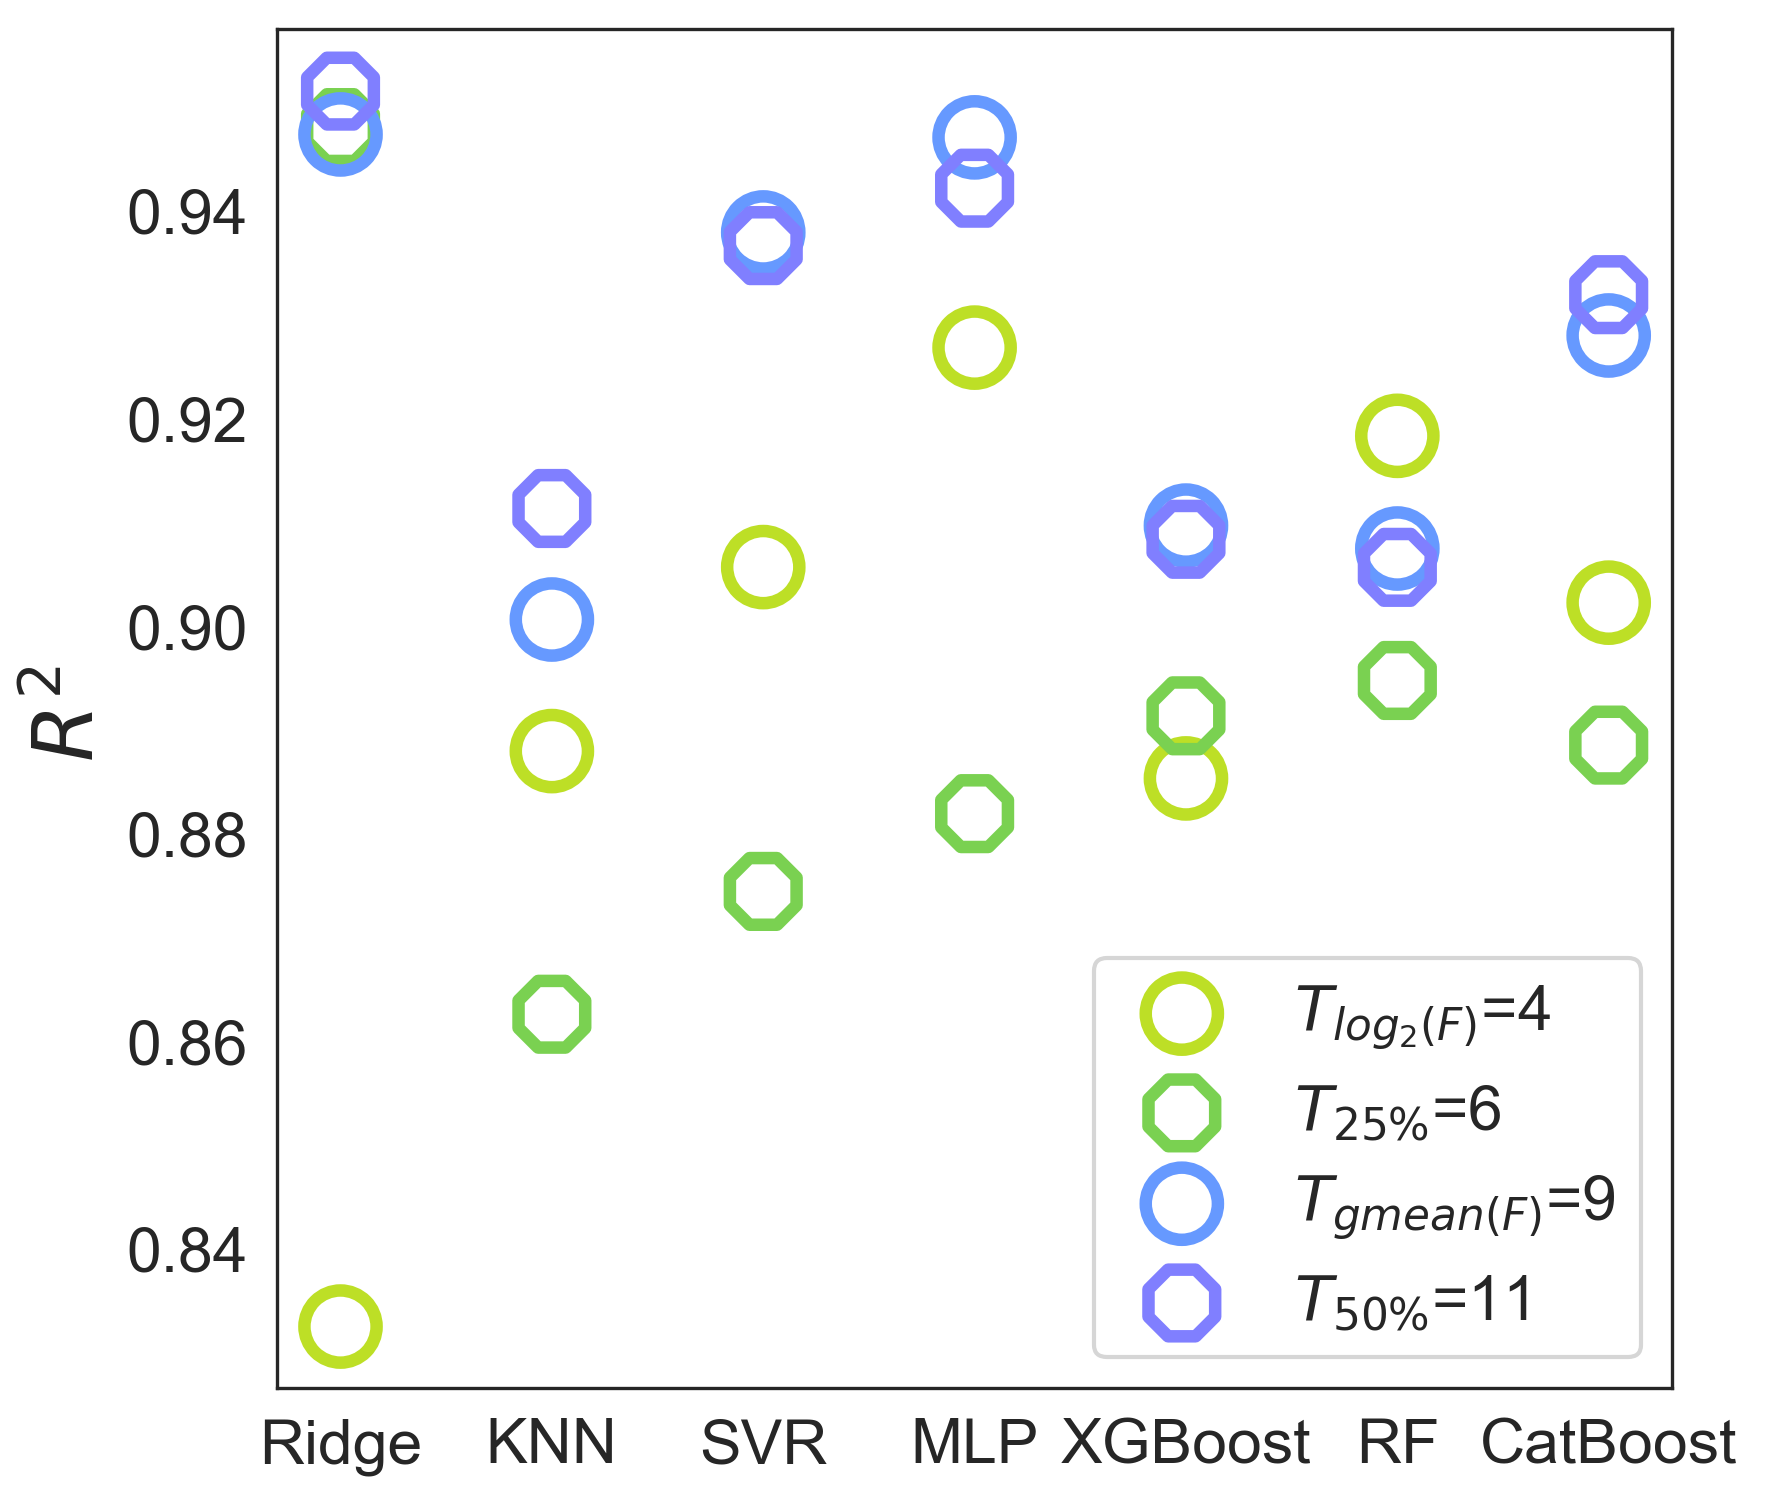

In [6]:
# 可视化

  
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

### cv10_r2可视化

In [67]:
cv10_4=pd.read_csv('20221025cv10_score_sum_logn.csv')
cv10_6=pd.read_csv('20221025cv10_score_sum_25.csv')
cv10_9=pd.read_csv('20221025cv10_score_sum_geo.csv')
cv10_11=pd.read_csv('20221025cv10_score_sum_50.csv')

thr_logn_cv10=(cv10_4.iloc[2,:].values[3:]).tolist()
thr_25_cv10=(cv10_6.iloc[2,:].values[3:]).tolist()
thr_geo_cv10=(cv10_9.iloc[2,:].values[3:]).tolist()
thr_50_cv10=(cv10_11.iloc[2,:].values[3:]).tolist()

data1_sum_cv10=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv10+=[thr_logn_cv10[i]]+[thr_25_cv10[i]]+[thr_geo_cv10[i]]+[thr_50_cv10[i]]
data1_sum_cv10=pd.DataFrame(data1_sum_cv10,columns=['cv10_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names
thr=[]

data1_sum_cv10['models']=models_names
data1_sum_cv10['thr']=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']*7
data1_sum_cv10

,cv10_r2,models,thr
0,0.851530,Ridge,thr_logn_cv10
1,0.957505,Ridge,thr_25_cv10
2,0.956594,Ridge,thr_geo_cv10
3,0.961624,Ridge,thr_50_cv10
4,0.907617,KNN,thr_logn_cv10
5,0.883148,KNN,thr_25_cv10
6,0.917703,KNN,thr_geo_cv10
7,0.914233,KNN,thr_50_cv10
8,0.925669,SVR,thr_logn_cv10
9,0.895626,SVR,thr_25_cv10


In [116]:
data1_sum_cv10.to_csv('20221025data1_sum_cv10.csv')

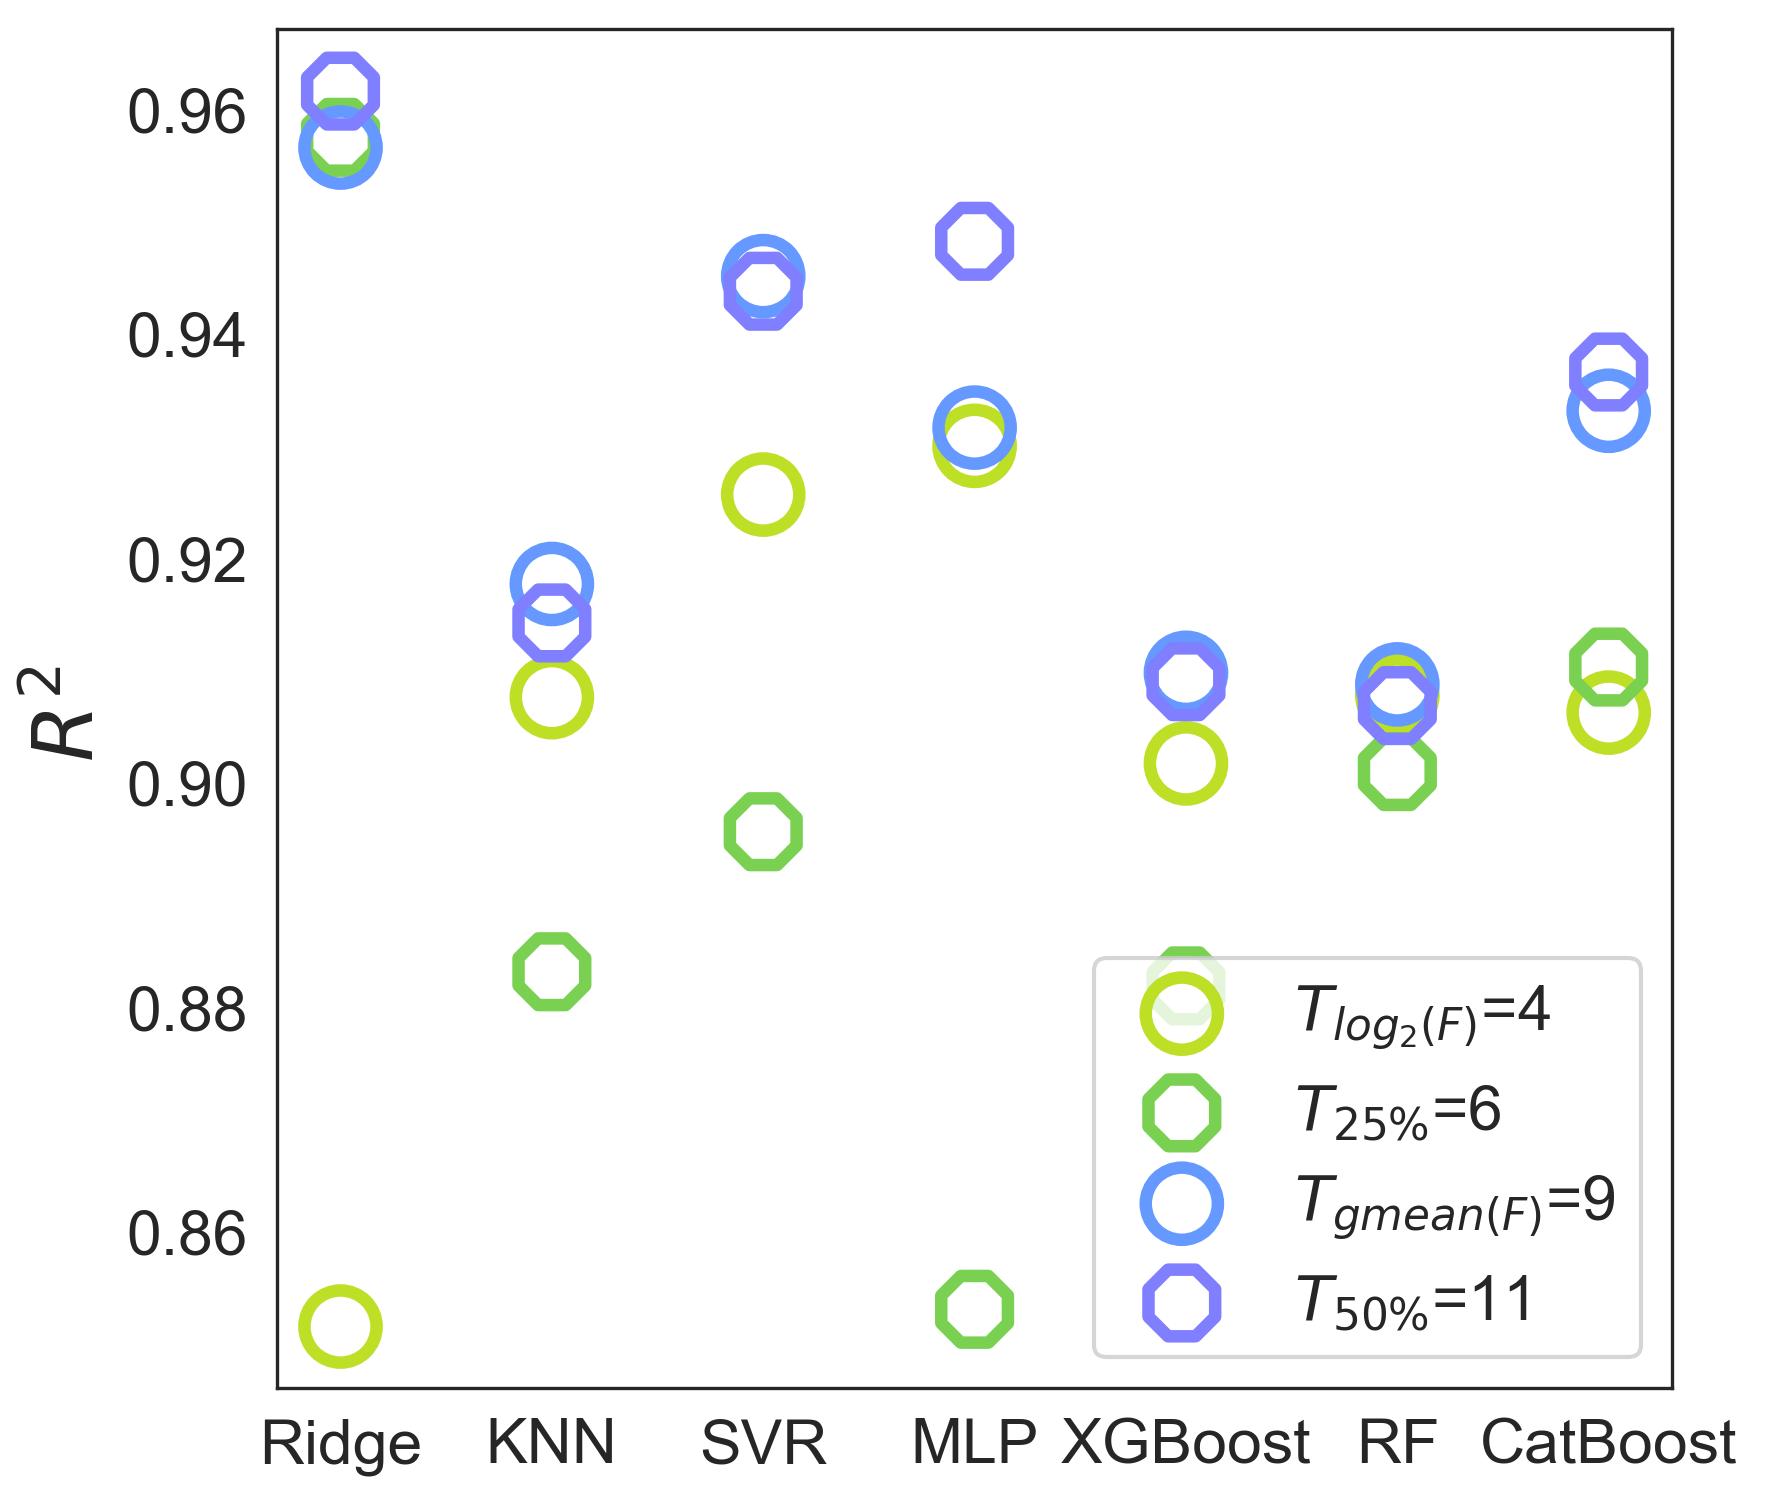

In [8]:
# 可视化

  
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

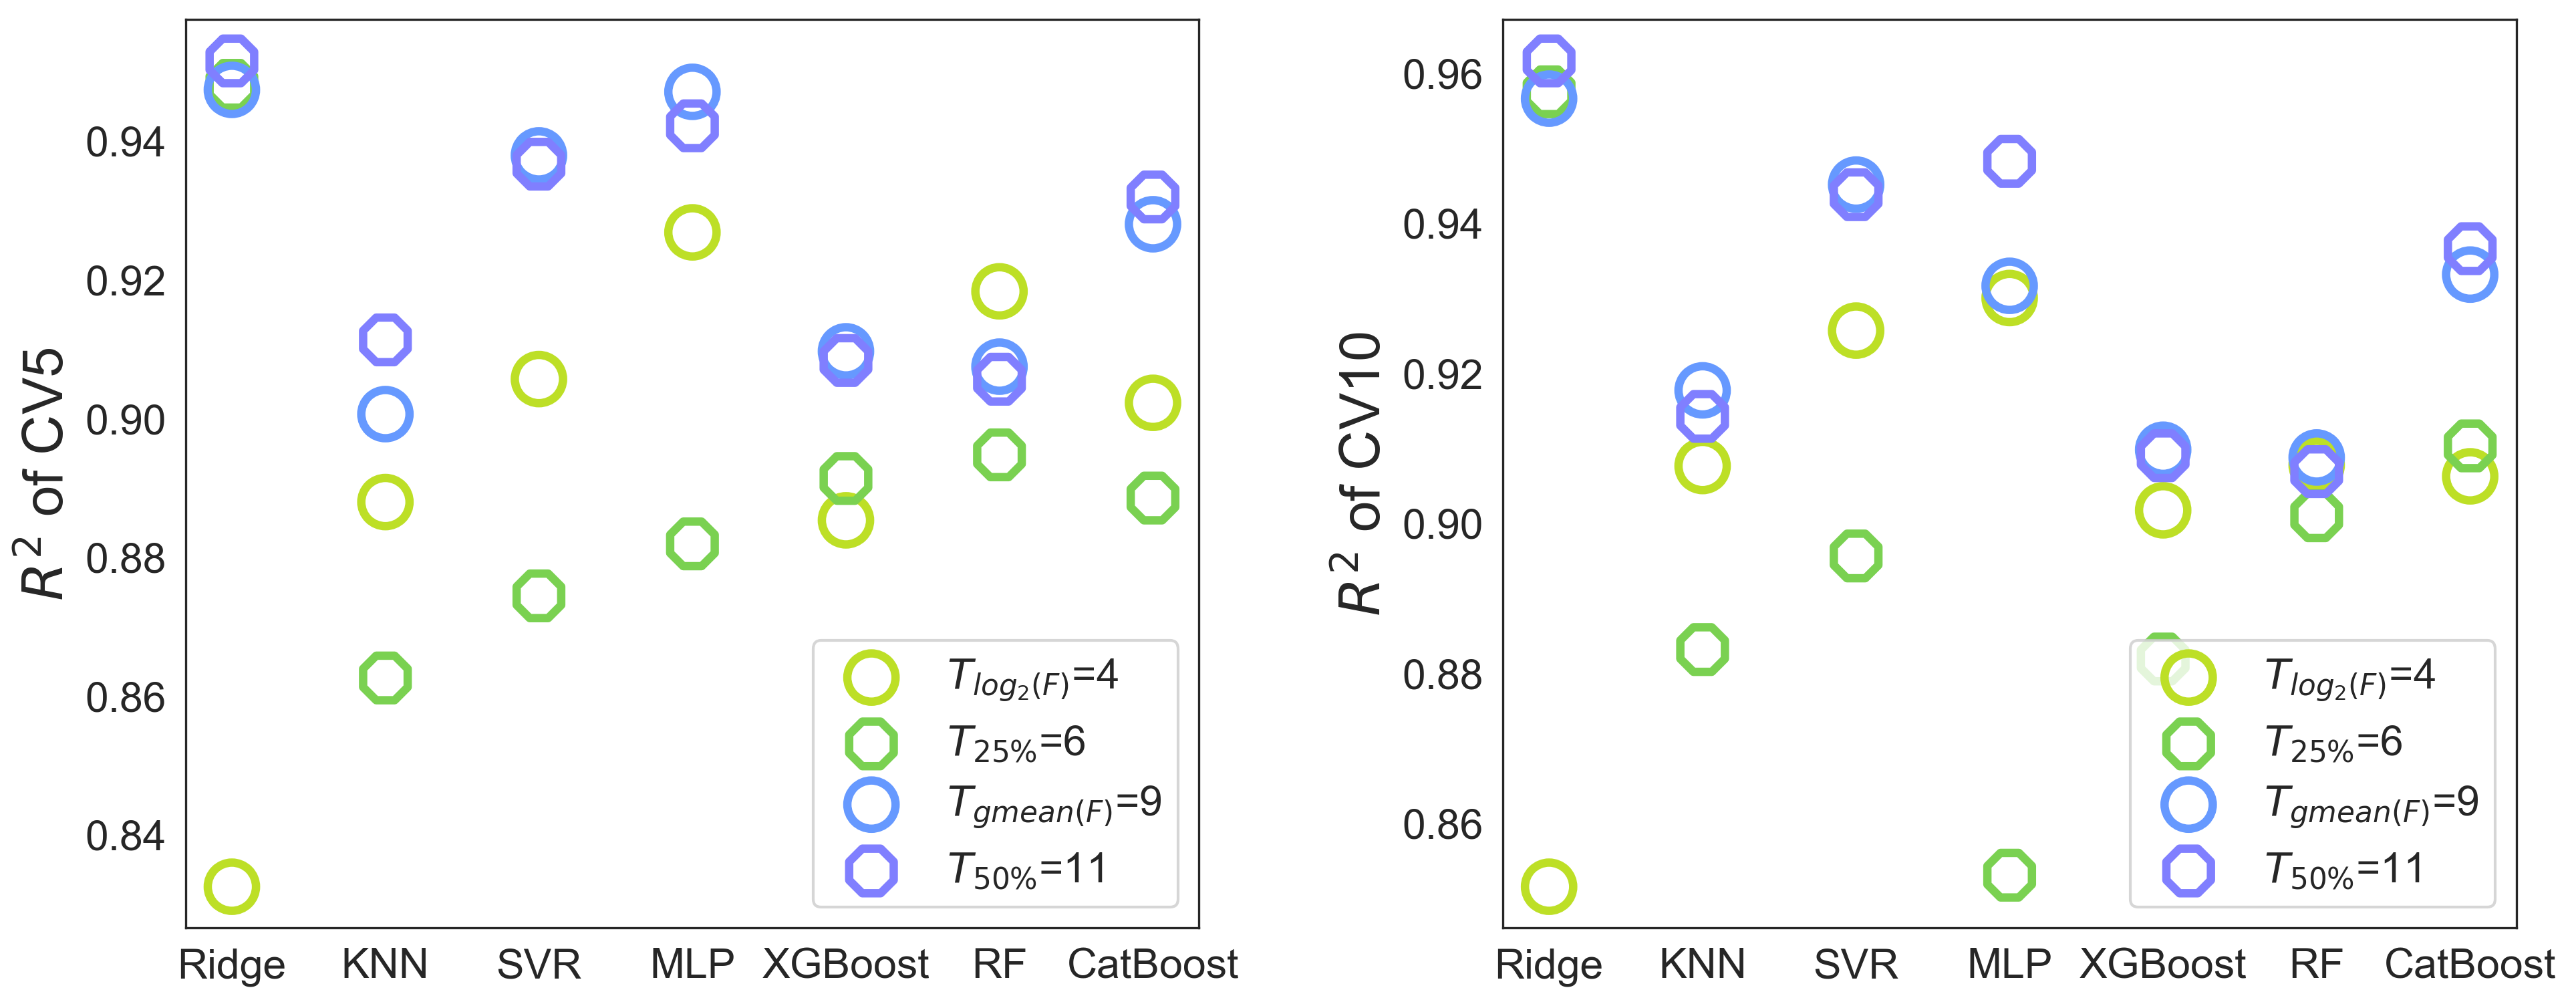

In [70]:
plt.figure(figsize=(15,6),dpi=300)
plt.subplot(1,2,1)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV5',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()

plt.subplot(1,2,2)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV10',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


## 重复实验——集成最优结果（平衡精度和复杂度）

In [ ]:
根据可视化结果，平衡模型复杂度和精度，五折和十折均选择6个特征  模型Ridge

十折：['f0', 'f11', 'f5', 'f20', 'f15', 'f21']

In [118]:
#验证最优特征子集
model=Ridge()
x_train=X_train[['f0', 'f11', 'f5', 'f20', 'f15', 'f21']]
x_test=X_test[['f0', 'f11', 'f5', 'f20', 'f15', 'f21']]
model=model.fit(x_train,y_train) 
y_pred_test= model.predict(x_test)
test_r2_=round(metrics.r2_score(y_test, y_pred_test),6)# a=[] a=计算公式 a.append(a) 会报错

cv10= KFold(n_splits=10, shuffle = True,random_state=0)
y_pred_cv10 = cross_val_predict(model,x_train,y_train, cv=cv10)
cv10_r2_=round(metrics.r2_score(y_train, y_pred_cv10),6)
cv10_r2_,test_r2_

(0.957505, 0.932724)

In [121]:
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]

X_25_cut=X[['f0', 'f11', 'f5', 'f20', 'f15', 'f21']]
data_25_cut=pd.concat([pd.DataFrame(y),X_25_cut],axis=1)
features=data_25_cut.columns[1:]
target=data_25_cut.columns[0]
num_bins = round(1 + np.log2(data_25_cut.shape[0]))
model=Ridge()

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_25_cut,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_micshap=df_result
df_result_mean_micshap=pd.DataFrame(df_result_micshap.mean()).T
df_result_mean_micshap['rs']=df_result_micshap.shape[0]
df_result_micshap

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

8
5
9
10
6
2
5
========220===========
8
5
9
10
6
2
5
========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
========245===========
8
5
9
10
6
2

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.948007,0.973774,11.986001,0.957505,0.978599,10.836076,0.932724,0.967111,13.436135
0,1,0.946489,0.972912,12.154885,0.946990,0.973155,12.097850,0.952600,0.978358,11.280320
0,2,0.959789,0.979778,10.690011,0.956364,0.978047,11.135999,0.916014,0.960484,14.102354
0,3,0.949657,0.974526,11.734299,0.952065,0.975757,11.450277,0.943595,0.972375,12.476459
0,4,0.952189,0.976043,11.461455,0.948819,0.974113,11.858431,0.960549,0.982185,10.355529
...,...,...,...,...,...,...,...,...,...,...
0,295,0.948390,0.974265,11.928781,0.953500,0.976520,11.322883,0.937519,0.970694,12.883957
0,296,0.960930,0.980272,10.436353,0.959701,0.979688,10.599218,0.912480,0.958946,15.046711
0,297,0.946150,0.972851,12.041410,0.937886,0.968452,12.932341,0.978825,0.990244,7.942263
0,298,0.957377,0.978682,10.840805,0.957394,0.978627,10.838669,0.932042,0.966886,13.581761


In [122]:
df_result_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.948007,0.973774,11.986001,0.957505,0.978599,10.836076,0.932724,0.967111,13.436135
0,1,0.946489,0.972912,12.154885,0.946990,0.973155,12.097850,0.952600,0.978358,11.280320
0,2,0.959789,0.979778,10.690011,0.956364,0.978047,11.135999,0.916014,0.960484,14.102354
0,3,0.949657,0.974526,11.734299,0.952065,0.975757,11.450277,0.943595,0.972375,12.476459
0,4,0.952189,0.976043,11.461455,0.948819,0.974113,11.858431,0.960549,0.982185,10.355529
...,...,...,...,...,...,...,...,...,...,...
0,295,0.948390,0.974265,11.928781,0.953500,0.976520,11.322883,0.937519,0.970694,12.883957
0,296,0.960930,0.980272,10.436353,0.959701,0.979688,10.599218,0.912480,0.958946,15.046711
0,297,0.946150,0.972851,12.041410,0.937886,0.968452,12.932341,0.978825,0.990244,7.942263
0,298,0.957377,0.978682,10.840805,0.957394,0.978627,10.838669,0.932042,0.966886,13.581761


In [123]:
df_result_micshap.to_csv('20221025df_result_micshap.csv')

In [124]:
df_result_mean_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.949771,0.974688,11.735151,0.950513,0.975002,11.651976,0.948819,0.97728,11.414131


### 基特征选择方法的比较

In [125]:
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]

num_bins =round(1 + np.log2(data_lmas.shape[0]))
features=data_lmas.columns[1:]
target=data_lmas.columns[0]
X_train,X_test,y_train,y_test = stratifed_sample_cut(data_lmas,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)


FN_new=6
data_mrmr=pd.concat([pd.DataFrame(y_train,columns=[target]),pd.DataFrame(X_train)],axis=1)
mRMR_features=pymrmr.mRMR(data_mrmr,'MID',FN_new)

f_score, pvalues_f = f_regression(X_train,y_train)
F_score=round(pd.DataFrame(list(zip(X_train.columns,f_score)),columns=['Features','Score_F']),6)
F_features=list(F_score.sort_values(by="Score_F",ascending=False)['Features'].values[:FN_new])

dcor_score=[]
for i in range(X_train.shape[1]):
    dcor_=dcor.distance_correlation(X_train.iloc[:,i], y_train).round(6)
    dcor_score.append(dcor_) 
Dcor_score=pd.DataFrame(list(zip(X_train.columns,dcor_score)),columns=['Features','Score_Dcor'])
Dcor_features=list(Dcor_score.sort_values(by="Score_Dcor",ascending=False)['Features'].values[:FN_new])

RF=RandomForestRegressor(random_state=0)
rfe=RFE(RF,n_features_to_select=FN_new,step=1)
selector=rfe.fit(X_train,y_train)
RFE_features=X_train.columns[rfe.get_support()]

# 基于RF 的嵌入式特征选择
RF=RandomForestRegressor(random_state=0)
RF.fit(X_train,y_train)
rffi_score=round(pd.DataFrame(list(zip(X_train.columns,RF.feature_importances_)),columns=['Features','Score_rffi']),6)
RFFI_features=list(rffi_score.sort_values(by="Score_rffi",ascending=False)['Features'].values[:FN_new])
mRMR_features,F_features,Dcor_features,RFE_features

8
5
9
10
6
2
5


(['f0', 'f9', 'f10', 'f17', 'f2', 'f19'],
 ['f11', 'f0', 'f17', 'f5', 'f15', 'f20'],
 ['f0', 'f11', 'f17', 'f15', 'f5', 'f20'],
 Index(['f0', 'f5', 'f11', 'f12', 'f17', 'f20'], dtype='object'))

#### mRMR

In [126]:
model=Ridge()
data_mRMR=pd.concat([pd.DataFrame(y),X[mRMR_features]],axis=1)
target=data_mRMR.columns[0]
features=data_mRMR.columns[1:]
num_bins = round(1 + np.log2(data_mRMR.shape[0]))


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_mRMR,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_mrmr=df_result   
df_result_mean_mrmr=pd.DataFrame(df_result_mrmr.mean()).T
df_result_mean_mrmr['rs']=df_result_mrmr.shape[0]
df_result_mrmr

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

9
10
6
2
5
========219===========
8
5
9
10
6
2
5
========220===========
8
5
9
10
6
2
5
========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.875539,0.936398,18.544650,0.896394,0.948330,16.919827,0.804046,0.907969,22.930973
0,1,0.891454,0.948547,17.311640,0.889254,0.946863,17.486148,0.947176,0.978088,11.908302
0,2,0.890649,0.947932,17.628530,0.881740,0.944934,18.332568,0.879689,0.952948,16.878800
0,3,0.891287,0.946919,17.243680,0.897550,0.952156,16.739607,0.882891,0.941960,17.977427
0,4,0.885489,0.945345,17.737748,0.907896,0.956672,15.907948,0.887491,0.942227,17.487835
...,...,...,...,...,...,...,...,...,...,...
0,295,0.757376,0.872816,25.864058,0.870961,0.936443,18.862110,0.910675,0.962907,15.404998
0,296,0.901574,0.950434,16.564658,0.899099,0.949107,16.771584,0.755391,0.875690,25.154940
0,297,0.860762,0.933752,19.362579,0.880777,0.942928,17.916971,0.962118,0.985848,10.623156
0,298,0.891976,0.946247,17.258395,0.898693,0.949573,16.713237,0.774661,0.897703,24.731643


In [129]:
df_result_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.875539,0.936398,18.544650,0.896394,0.948330,16.919827,0.804046,0.907969,22.930973
0,1,0.891454,0.948547,17.311640,0.889254,0.946863,17.486148,0.947176,0.978088,11.908302
0,2,0.890649,0.947932,17.628530,0.881740,0.944934,18.332568,0.879689,0.952948,16.878800
0,3,0.891287,0.946919,17.243680,0.897550,0.952156,16.739607,0.882891,0.941960,17.977427
0,4,0.885489,0.945345,17.737748,0.907896,0.956672,15.907948,0.887491,0.942227,17.487835
...,...,...,...,...,...,...,...,...,...,...
0,295,0.757376,0.872816,25.864058,0.870961,0.936443,18.862110,0.910675,0.962907,15.404998
0,296,0.901574,0.950434,16.564658,0.899099,0.949107,16.771584,0.755391,0.875690,25.154940
0,297,0.860762,0.933752,19.362579,0.880777,0.942928,17.916971,0.962118,0.985848,10.623156
0,298,0.891976,0.946247,17.258395,0.898693,0.949573,16.713237,0.774661,0.897703,24.731643


In [130]:
df_result_mrmr.to_csv('20221025df_result_mrmr.csv')

In [131]:
df_result_mean_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.869644,0.936302,18.880088,0.885392,0.944618,17.738103,0.904501,0.958504,15.364104


#### F检验

In [133]:
data_F=pd.concat([pd.DataFrame(y),X[F_features]],axis=1)
features=data_F.columns[1:]
target=data_F.columns[0]
num_bins = round(1 + np.log2(data_F.shape[0]))
model=Ridge()

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_F,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_f=df_result   
df_result_mean_f=pd.DataFrame(df_result_f.mean()).T
df_result_mean_f['rs']=df_result_f.shape[0]
df_result_f

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

8
5
9
10
6
2
5
========220===========
8
5
9
10
6
2
5
========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
========245===========
8
5
9
10
6
2

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.815192,0.904167,22.597652,0.838456,0.915728,21.127468,0.671108,0.832265,29.707941
0,1,0.810654,0.900707,22.864352,0.807293,0.898781,23.066351,0.869662,0.936012,18.705497
0,2,0.773583,0.879976,25.366451,0.788303,0.888512,24.528031,0.848130,0.931381,18.963763
0,3,0.771807,0.880715,24.982694,0.780749,0.884795,24.488323,0.886633,0.946150,17.687920
0,4,0.779654,0.883609,24.605223,0.779270,0.883493,24.626622,0.921085,0.966526,14.646123
...,...,...,...,...,...,...,...,...,...,...
0,295,0.739933,0.863625,26.777668,0.803399,0.896716,23.282130,0.820896,0.908122,21.813667
0,296,0.862838,0.928934,19.554392,0.865044,0.930082,19.396478,0.601148,0.809502,32.121273
0,297,0.770007,0.877984,24.885203,0.800665,0.895184,23.167329,0.880018,0.950747,18.905800
0,298,0.845369,0.919597,20.648475,0.851574,0.922907,20.229947,0.649649,0.821523,30.837988


In [134]:
df_result_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.815192,0.904167,22.597652,0.838456,0.915728,21.127468,0.671108,0.832265,29.707941
0,1,0.810654,0.900707,22.864352,0.807293,0.898781,23.066351,0.869662,0.936012,18.705497
0,2,0.773583,0.879976,25.366451,0.788303,0.888512,24.528031,0.848130,0.931381,18.963763
0,3,0.771807,0.880715,24.982694,0.780749,0.884795,24.488323,0.886633,0.946150,17.687920
0,4,0.779654,0.883609,24.605223,0.779270,0.883493,24.626622,0.921085,0.966526,14.646123
...,...,...,...,...,...,...,...,...,...,...
0,295,0.739933,0.863625,26.777668,0.803399,0.896716,23.282130,0.820896,0.908122,21.813667
0,296,0.862838,0.928934,19.554392,0.865044,0.930082,19.396478,0.601148,0.809502,32.121273
0,297,0.770007,0.877984,24.885203,0.800665,0.895184,23.167329,0.880018,0.950747,18.905800
0,298,0.845369,0.919597,20.648475,0.851574,0.922907,20.229947,0.649649,0.821523,30.837988


In [135]:
df_result_f.to_csv('20221025df_result_f.csv')

In [136]:
df_result_mean_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.797367,0.893531,23.572317,0.802769,0.896311,23.267568,0.830645,0.922251,20.808672


#### 距离相关系数

In [137]:
data_Dcor=pd.concat([pd.DataFrame(y),X[Dcor_features]],axis=1)
features=data_Dcor.columns[1:]
target=data_Dcor.columns[0]
num_bins = round(1 + np.log2(data_Dcor.shape[0]))
model=Ridge()


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_Dcor,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_dcor=df_result   
df_result_mean_dcor=pd.DataFrame(df_result_dcor.mean()).T
df_result_mean_dcor['rs']=df_result_dcor.shape[0]
df_result_dcor

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

========219===========
8
5
9
10
6
2
5
========220===========
8
5
9
10
6
2
5
========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
========245=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.815192,0.904167,22.597652,0.838456,0.915728,21.127468,0.671108,0.832265,29.707941
0,1,0.810654,0.900707,22.864352,0.807293,0.898781,23.066351,0.869662,0.936012,18.705497
0,2,0.773583,0.879976,25.366451,0.788303,0.888512,24.528031,0.848130,0.931381,18.963763
0,3,0.771807,0.880715,24.982694,0.780749,0.884795,24.488323,0.886633,0.946150,17.687920
0,4,0.779654,0.883609,24.605223,0.779270,0.883493,24.626622,0.921085,0.966526,14.646123
...,...,...,...,...,...,...,...,...,...,...
0,295,0.739933,0.863625,26.777668,0.803399,0.896716,23.282130,0.820896,0.908122,21.813667
0,296,0.862838,0.928934,19.554392,0.865044,0.930082,19.396478,0.601148,0.809502,32.121273
0,297,0.770007,0.877984,24.885203,0.800665,0.895184,23.167329,0.880018,0.950747,18.905800
0,298,0.845369,0.919597,20.648475,0.851574,0.922907,20.229947,0.649649,0.821523,30.837988


In [138]:
df_result_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.815192,0.904167,22.597652,0.838456,0.915728,21.127468,0.671108,0.832265,29.707941
0,1,0.810654,0.900707,22.864352,0.807293,0.898781,23.066351,0.869662,0.936012,18.705497
0,2,0.773583,0.879976,25.366451,0.788303,0.888512,24.528031,0.848130,0.931381,18.963763
0,3,0.771807,0.880715,24.982694,0.780749,0.884795,24.488323,0.886633,0.946150,17.687920
0,4,0.779654,0.883609,24.605223,0.779270,0.883493,24.626622,0.921085,0.966526,14.646123
...,...,...,...,...,...,...,...,...,...,...
0,295,0.739933,0.863625,26.777668,0.803399,0.896716,23.282130,0.820896,0.908122,21.813667
0,296,0.862838,0.928934,19.554392,0.865044,0.930082,19.396478,0.601148,0.809502,32.121273
0,297,0.770007,0.877984,24.885203,0.800665,0.895184,23.167329,0.880018,0.950747,18.905800
0,298,0.845369,0.919597,20.648475,0.851574,0.922907,20.229947,0.649649,0.821523,30.837988


In [139]:
df_result_dcor.to_csv('20221025df_result_dcor.csv')

In [140]:
df_result_mean_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.797367,0.893531,23.572317,0.802769,0.896311,23.267568,0.830645,0.922251,20.808672


#### RF-RFE

In [141]:
data_RFE=pd.concat([pd.DataFrame(y),X[RFE_features]],axis=1)
features=data_RFE.columns[1:]
target=data_RFE.columns[0]
num_bins = round(1 + np.log2(data_RFE.shape[0]))
model=Ridge()


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFE,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rfrfe=df_result   
df_result_mean_rfrfe=pd.DataFrame(df_result_rfrfe.mean()).T
df_result_mean_rfrfe['rs']=df_result_rfrfe.shape[0]
df_result_rfrfe

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
========245===========
8
5
9
10
6
2
5
========246===========
8
5
9
10
6
2
5
========247=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.817334,0.905372,22.466301,0.839099,0.916085,21.085382,0.679911,0.837950,29.307670
0,1,0.813274,0.902187,22.705585,0.810288,0.900451,22.886431,0.877430,0.940284,18.139516
0,2,0.777098,0.882009,25.168793,0.792438,0.890961,24.287276,0.846205,0.933014,19.083601
0,3,0.776509,0.883334,24.723991,0.784279,0.886789,24.290364,0.888983,0.947500,17.503625
0,4,0.784079,0.886122,24.356906,0.782396,0.885307,24.451640,0.922152,0.967922,14.546720
...,...,...,...,...,...,...,...,...,...,...
0,295,0.747636,0.868068,26.378096,0.813845,0.902595,22.655175,0.816407,0.907012,22.085370
0,296,0.867979,0.931697,19.184402,0.868734,0.932066,19.129475,0.616724,0.816477,31.487855
0,297,0.768072,0.877044,24.989639,0.800478,0.895153,23.178190,0.883825,0.952887,18.603476
0,298,0.846854,0.920361,20.549073,0.852527,0.923420,20.164921,0.660431,0.828352,30.359774


In [142]:
df_result_rfrfe.to_csv('20221025df_result_rfrfe.csv')

In [143]:
df_result_mean_rfrfe

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.801,0.895573,23.358127,0.806494,0.898397,23.044411,0.834484,0.924636,20.559956


#### RF 特征重要性

In [144]:
data_RFFI=pd.concat([pd.DataFrame(y),X[RFFI_features]],axis=1)
features=data_RFFI.columns[1:]
target=data_RFFI.columns[0]
num_bins = round(1 + np.log2(data_RFFI.shape[0]))
model=Ridge()


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFFI,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rffi=df_result   
df_result_mean_rffi=pd.DataFrame(df_result_rffi.mean()).T
df_result_mean_rffi['rs']=df_result_rffi.shape[0]
df_result_rffi

========0===========
8
5
9
10
6
2
5
========1===========
8
5
9
10
6
2
5
========2===========
8
5
9
10
6
2
5
========3===========
8
5
9
10
6
2
5
========4===========
8
5
9
10
6
2
5
========5===========
8
5
9
10
6
2
5
========6===========
8
5
9
10
6
2
5
========7===========
8
5
9
10
6
2
5
========8===========
8
5
9
10
6
2
5
========9===========
8
5
9
10
6
2
5
========10===========
8
5
9
10
6
2
5
========11===========
8
5
9
10
6
2
5
========12===========
8
5
9
10
6
2
5
========13===========
8
5
9
10
6
2
5
========14===========
8
5
9
10
6
2
5
========15===========
8
5
9
10
6
2
5
========16===========
8
5
9
10
6
2
5
========17===========
8
5
9
10
6
2
5
========18===========
8
5
9
10
6
2
5
========19===========
8
5
9
10
6
2
5
========20===========
8
5
9
10
6
2
5
========21===========
8
5
9
10
6
2
5
========22===========
8
5
9
10
6
2
5
========23===========
8
5
9
10
6
2
5
========24===========
8
5
9
10
6
2
5
========25===========
8
5
9
10
6
2
5
========26===========
8
5
9
10
6
2
5
========27=

8
5
9
10
6
2
5
========220===========
8
5
9
10
6
2
5
========221===========
8
5
9
10
6
2
5
========222===========
8
5
9
10
6
2
5
========223===========
8
5
9
10
6
2
5
========224===========
8
5
9
10
6
2
5
========225===========
8
5
9
10
6
2
5
========226===========
8
5
9
10
6
2
5
========227===========
8
5
9
10
6
2
5
========228===========
8
5
9
10
6
2
5
========229===========
8
5
9
10
6
2
5
========230===========
8
5
9
10
6
2
5
========231===========
8
5
9
10
6
2
5
========232===========
8
5
9
10
6
2
5
========233===========
8
5
9
10
6
2
5
========234===========
8
5
9
10
6
2
5
========235===========
8
5
9
10
6
2
5
========236===========
8
5
9
10
6
2
5
========237===========
8
5
9
10
6
2
5
========238===========
8
5
9
10
6
2
5
========239===========
8
5
9
10
6
2
5
========240===========
8
5
9
10
6
2
5
========241===========
8
5
9
10
6
2
5
========242===========
8
5
9
10
6
2
5
========243===========
8
5
9
10
6
2
5
========244===========
8
5
9
10
6
2
5
========245===========
8
5
9
10
6
2

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.837218,0.915967,21.208306,0.855910,0.925174,19.953525,0.710977,0.857965,27.849142
0,1,0.834752,0.913993,21.359861,0.839038,0.916176,21.081075,0.897840,0.952504,16.560500
0,2,0.815586,0.903426,22.892969,0.827924,0.910768,22.113894,0.847659,0.938132,18.993140
0,3,0.813896,0.903443,22.561409,0.816654,0.904353,22.393609,0.906384,0.956709,16.073419
0,4,0.813140,0.902320,22.658593,0.813306,0.902404,22.648510,0.941627,0.976681,12.596413
...,...,...,...,...,...,...,...,...,...,...
0,295,0.792957,0.892816,23.892397,0.850073,0.922635,20.331503,0.823852,0.911485,21.632898
0,296,0.881043,0.938710,18.210511,0.882292,0.939323,18.114652,0.673253,0.841438,29.073189
0,297,0.801094,0.895571,23.142373,0.821636,0.906864,21.914766,0.902718,0.960461,17.023735
0,298,0.858922,0.926911,19.722816,0.865077,0.930174,19.287845,0.705967,0.855558,28.250922


In [145]:
df_result_rffi.to_csv('20221025df_result_rffi.csv')

In [146]:
df_result_mean_rffi

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.826979,0.909845,21.779912,0.833234,0.913103,21.39421,0.858081,0.936393,18.906218


### 得分汇总—5折交叉验证

In [147]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_5=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_5_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_5):
    result_5_R2=pd.concat([result_5_R2,pd.DataFrame(result['cv5_r2'])],axis=1)
result_5_R2.columns=fs_name
result_5_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.948007,0.875539,0.815192,0.815192,0.817334,0.837218
0,0.946489,0.891454,0.810654,0.810654,0.813274,0.834752
0,0.959789,0.890649,0.773583,0.773583,0.777098,0.815586
0,0.949657,0.891287,0.771807,0.771807,0.776509,0.813896
0,0.952189,0.885489,0.779654,0.779654,0.784079,0.813140
...,...,...,...,...,...,...
0,0.948390,0.757376,0.739933,0.739933,0.747636,0.792957
0,0.960930,0.901574,0.862838,0.862838,0.867979,0.881043
0,0.946150,0.860762,0.770007,0.770007,0.768072,0.801094
0,0.957377,0.891976,0.845369,0.845369,0.846854,0.858922


In [148]:
result_5_R2.to_csv('20221025result_5_R2.csv')

#### 配对T检验

In [157]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j   备择假设   i对应特征选择优于j对应特征选择

In [158]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


### 得分汇总—10折交叉验证

In [159]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_10=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_10_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_10):
    result_10_R2=pd.concat([result_10_R2,pd.DataFrame(result['cv10_r2'])],axis=1)
result_10_R2.columns=fs_name
result_10_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.957505,0.896394,0.838456,0.838456,0.839099,0.855910
0,0.946990,0.889254,0.807293,0.807293,0.810288,0.839038
0,0.956364,0.881740,0.788303,0.788303,0.792438,0.827924
0,0.952065,0.897550,0.780749,0.780749,0.784279,0.816654
0,0.948819,0.907896,0.779270,0.779270,0.782396,0.813306
...,...,...,...,...,...,...
0,0.953500,0.870961,0.803399,0.803399,0.813845,0.850073
0,0.959701,0.899099,0.865044,0.865044,0.868734,0.882292
0,0.937886,0.880777,0.800665,0.800665,0.800478,0.821636
0,0.957394,0.898693,0.851574,0.851574,0.852527,0.865077


In [160]:
result_10_R2.to_csv('20221025result_10_R2.csv')

#### 配对T检验

In [162]:
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j 备择假设 i对应特征选择优于j对应特征选择

In [163]:
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.0,0.0,0.0
F检验,,,,,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


## SHAP可解释性 

In [5]:
# random_state=0
data_lmas=pd.read_csv('total_data.csv')
data_lmas
X=data_lmas.iloc[:,1:]
y=data_lmas.iloc[:,0]

num_bins = round(1 + np.log2(data_lmas.shape[0]))# 最优箱数四舍五入
features=data_lmas.columns[1:]
target=data_lmas.columns[0]
X_train,X_test,y_train,y_test = stratifed_sample_cut(data_lmas,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

8
5
9
10
6
2
5


In [ ]:
['f0', 'f11', 'f5', 'f20', 'f15', 'f21']
 
Xsn B XGa R T △R 

![jupyter](./22特征.png)

In [47]:
X_train_=X_train[['f0', 'f11', 'f5', 'f20', 'f15', 'f21']]
X_train_.columns=['$X_{Sn}$','$\textit{B}$','$X_{Ga}$','$\textit{R}$','$\textit{T}$','$\textit{△R }$ ']
X_train_

,$X_{Sn}$,$\textit{B}$,$X_{Ga}$,$\textit{R}$,$\textit{T}$,$\textit{△R }$
0,-0.711046,-1.175956,1.733464,-1.641926,-1.836414,-0.230896
1,-1.156664,-1.427976,2.450464,-2.340179,-2.199072,-2.400561
2,-1.156664,-1.578248,2.462247,-2.246216,-2.322850,-2.466652
3,-0.572471,-0.963325,2.016342,-1.940435,-1.892205,-0.944242
4,-1.156664,-0.999784,1.717620,-1.980492,-1.482398,-0.211225
5,-0.815740,-1.270471,2.293051,-2.132366,-2.152846,-1.752330
6,-1.156664,-1.322452,2.363420,-2.321139,-2.075859,-1.966005
7,-1.156664,-1.578248,2.044994,-1.871829,-2.105666,-1.133609
8,-0.472527,-0.960626,-0.461665,0.391428,-0.316239,0.312884
9,-0.079271,-0.188017,-0.461665,0.500901,0.231355,0.873005


In [6]:
X_train_=X_train[['f0', 'f11', 'f5', 'f20', 'f15', 'f21']]
X_train_.columns=['$X_{Sn}$','B','$X_{Ga}$','R','T','△R']
X_train_
model=Ridge()
model.fit(X_train_,y_train)
explainer = shap.explainers.Permutation(model.predict, X_train_)
shap_values = explainer(X_train_)

In [7]:
SHAP_score=pd.DataFrame(shap_values.values).apply(lambda x:abs(x)).mean()
SHAP_score=round(pd.DataFrame(SHAP_score),6)
SHAP_score

,0
0,14.765287
1,12.306131
2,6.022047
3,12.092687
4,9.228956
5,21.553948


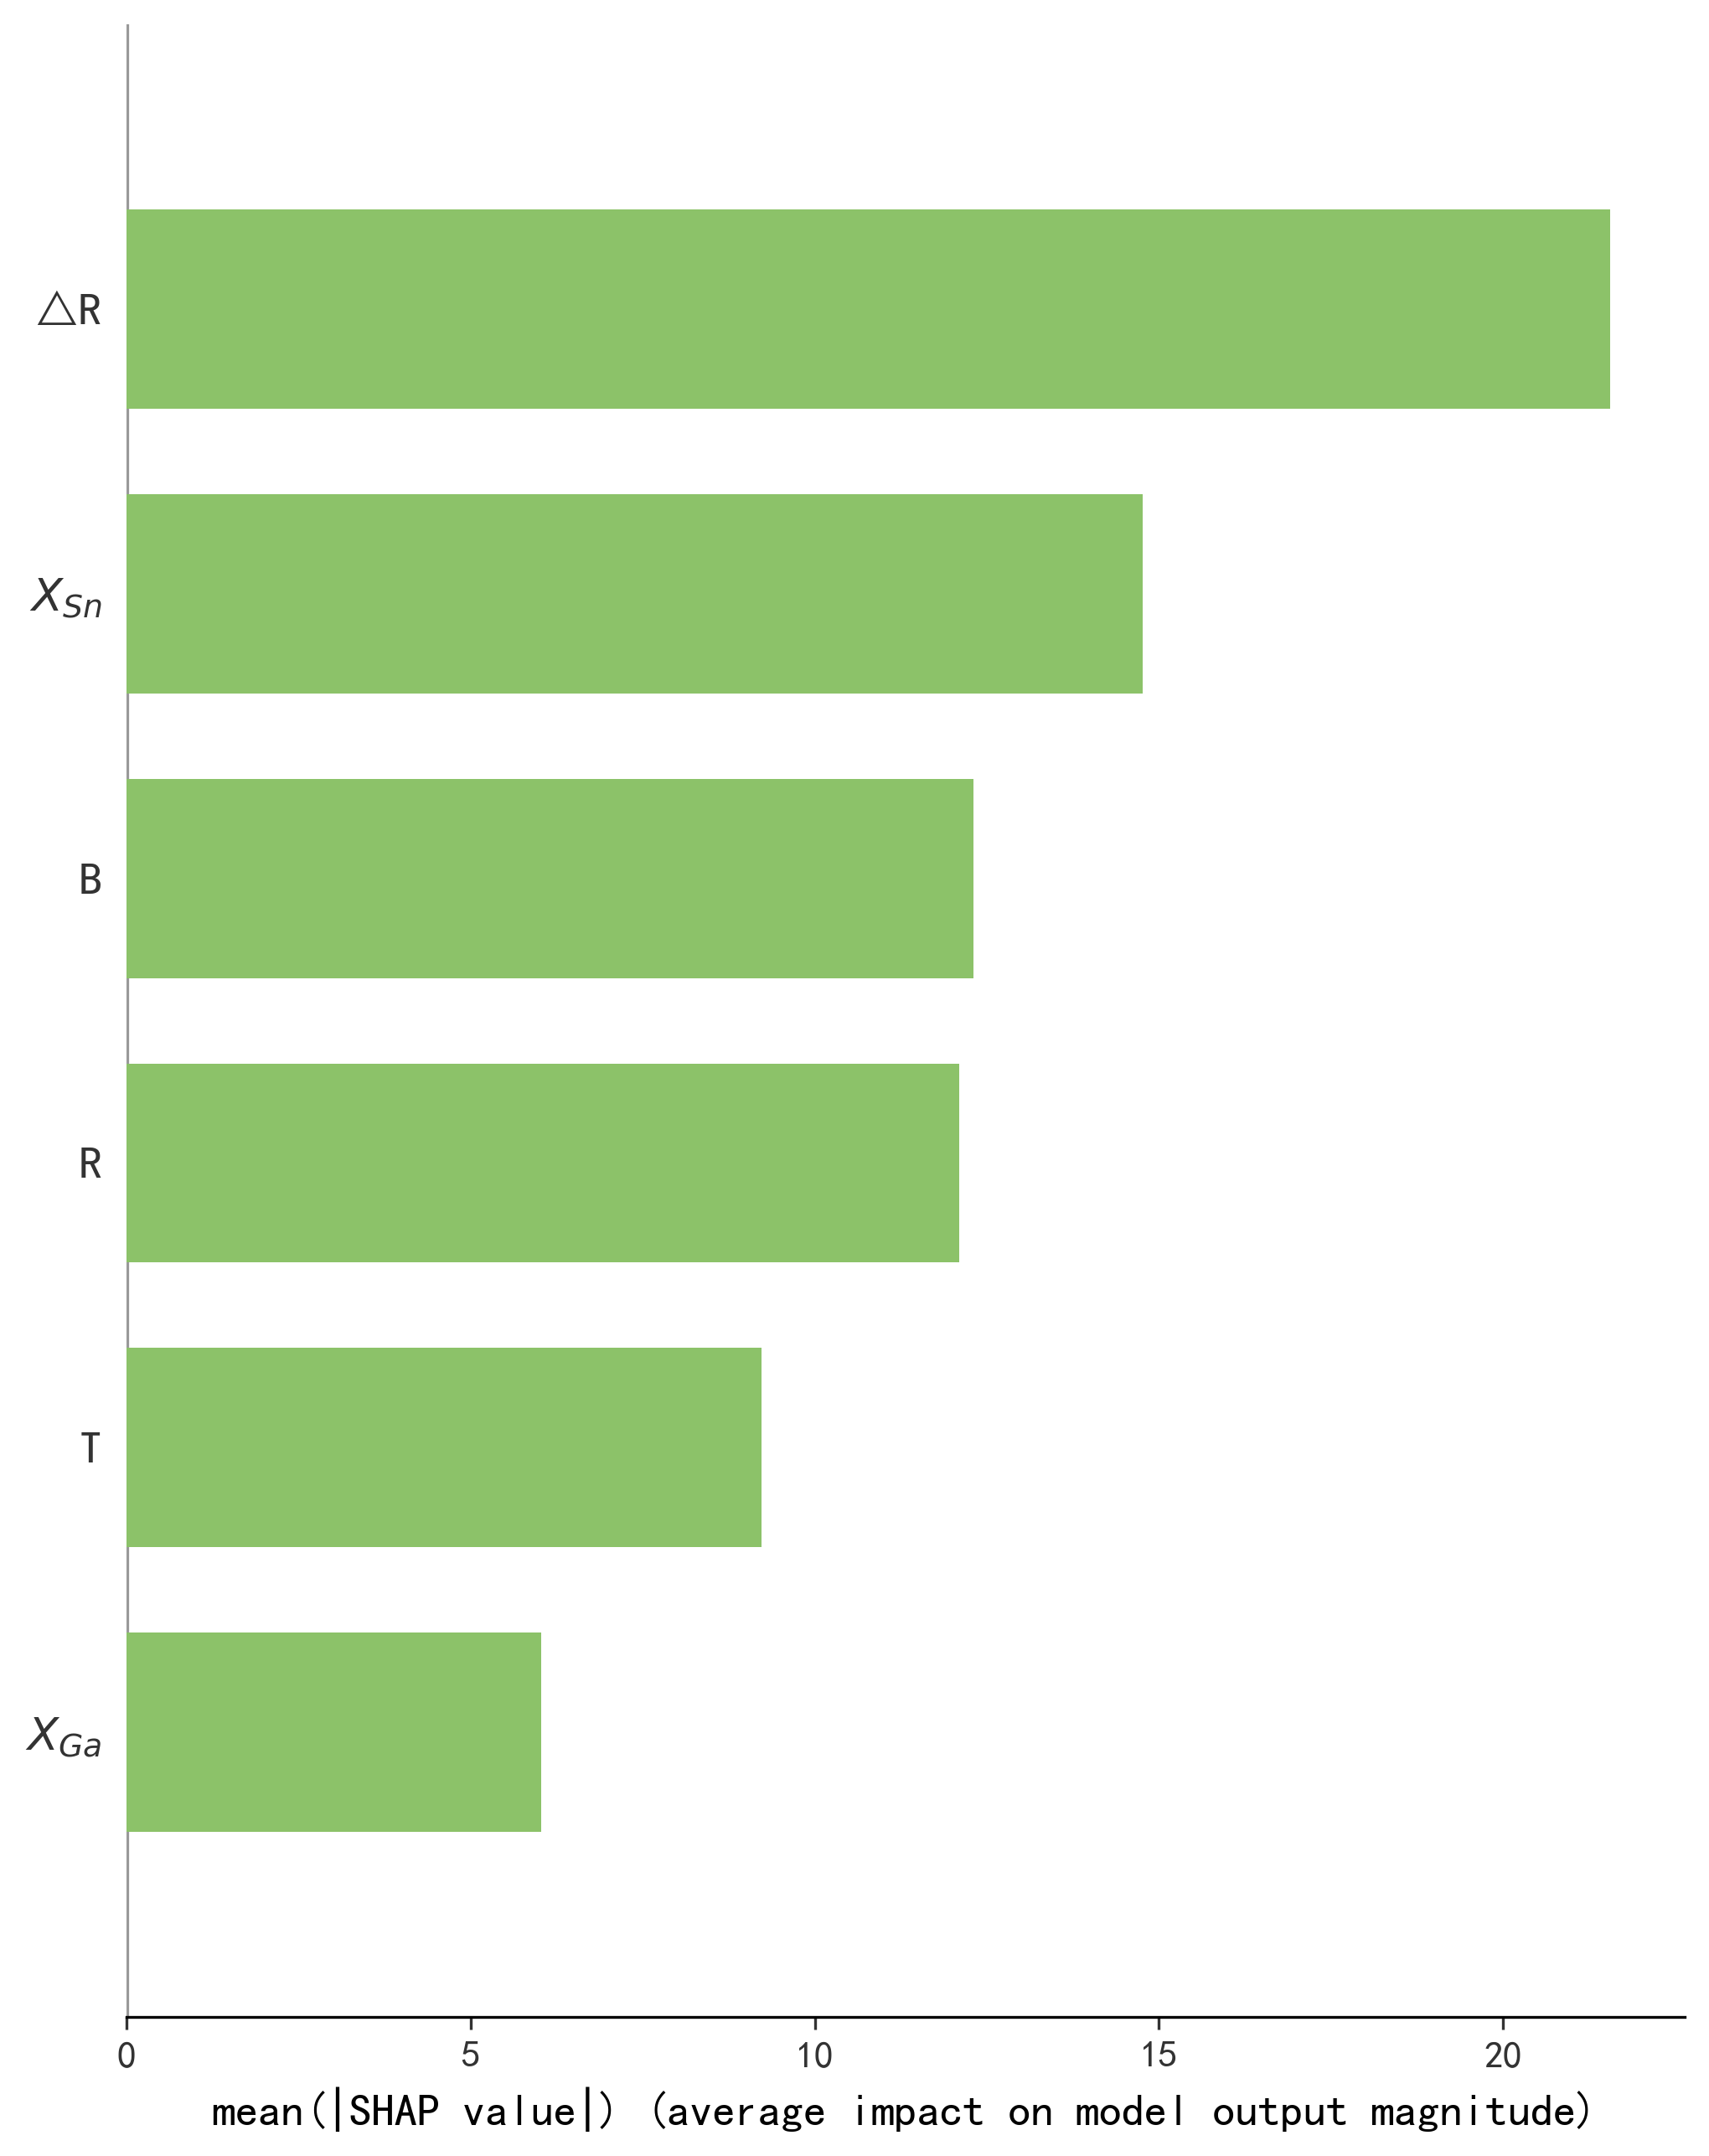

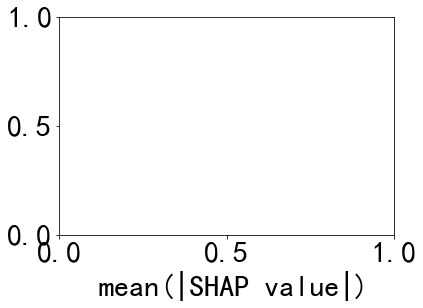

In [12]:
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False   #显示负号
plt.figure(figsize=(12,8),dpi=300)
shap.summary_plot(shap_values, X_train_, plot_type="bar",color='#8cc269',plot_size=1.5)
plt.xlabel(" mean(|SHAP value|)" ,fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

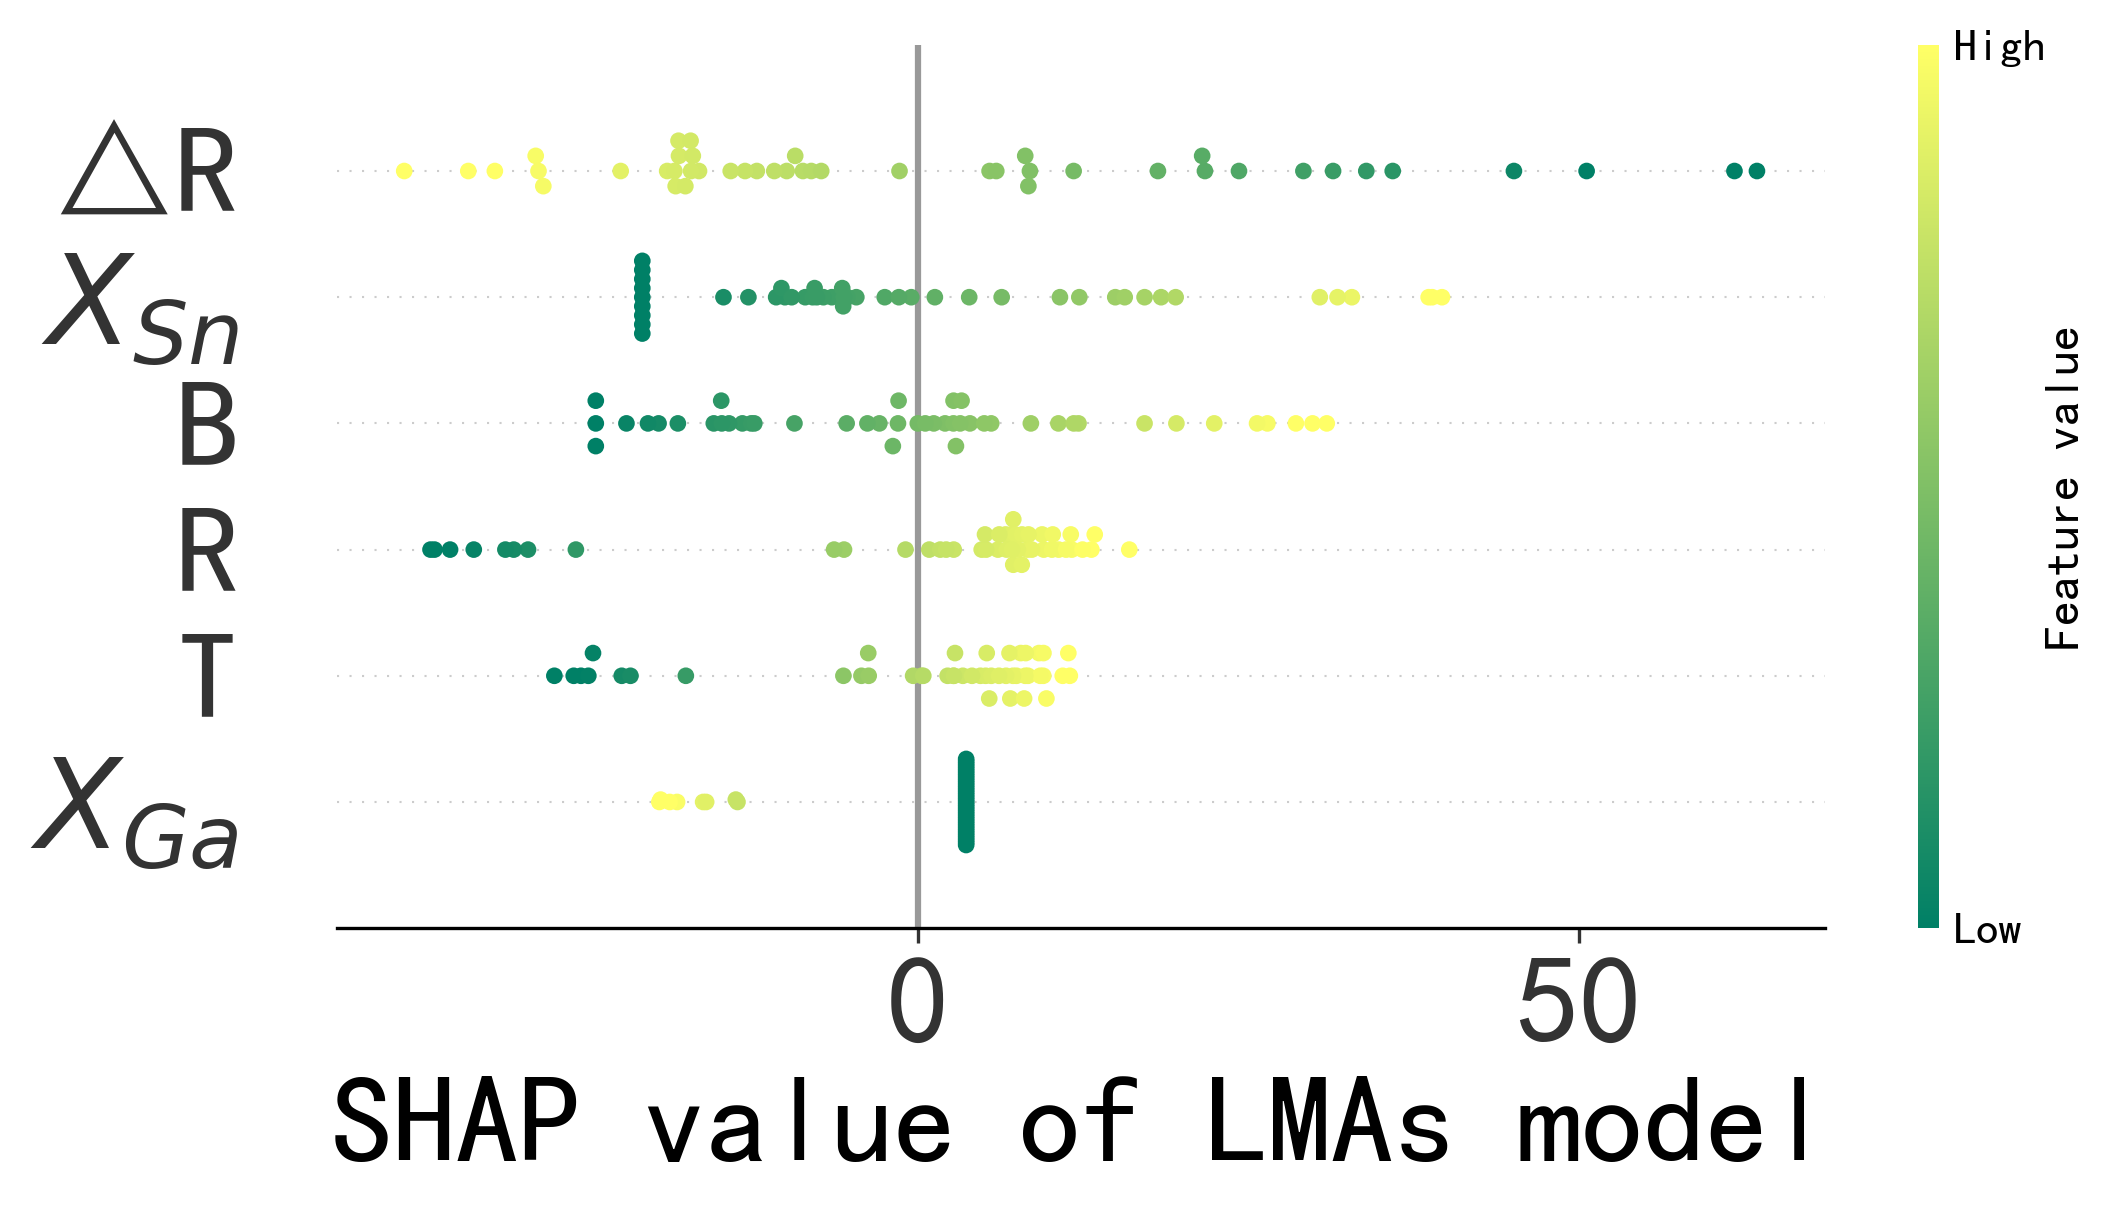

In [14]:
color1=(140,194,105)
color2=(248,223,112)
plt.figure(figsize=(12,8),dpi=300)
shap.summary_plot(shap_values, X_train_,show=False,cmap=plt.get_cmap("summer"))#color_bar=False
plt.xlabel("SHAP value of LMAs model" ,fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

## MIC 热图

In [16]:
data_xbest_y=pd.concat([pd.DataFrame(y_train,columns=['Target']),X_train_],axis=1)
data_xbest_y

,Target,$X_{Sn}$,B,$X_{Ga}$,R,T,△R
0,11.00,-0.711046,-1.175956,1.733464,-1.641926,-1.836414,-0.230896
1,25.00,-1.156664,-1.427976,2.450464,-2.340179,-2.199072,-2.400561
2,15.70,-1.156664,-1.578248,2.462247,-2.246216,-2.322850,-2.466652
3,20.20,-0.572471,-0.963325,2.016342,-1.940435,-1.892205,-0.944242
4,10.70,-1.156664,-0.999784,1.717620,-1.980492,-1.482398,-0.211225
5,20.55,-0.815740,-1.270471,2.293051,-2.132366,-2.152846,-1.752330
6,24.60,-1.156664,-1.322452,2.363420,-2.321139,-2.075859,-1.966005
7,15.70,-1.156664,-1.578248,2.044994,-1.871829,-2.105666,-1.133609
8,60.42,-0.472527,-0.960626,-0.461665,0.391428,-0.316239,0.312884
9,60.00,-0.079271,-0.188017,-0.461665,0.500901,0.231355,0.873005


In [60]:
data_xbest_y.columns=['Target', '$X_{Sn}$', 'B', '$X_{Ga}$', 'R',
       'T', '△R']


In [ ]:
data_xbest_y.columns=['Target', '△R' '$X_{Sn}$', 'B', '$X_{Ga}$', 'R',
       'T',]

In [15]:
data_xbest_y.columns=['Target','f0', 'f11', 'f5', 'f20', 'f15', 'f21']

In [17]:
def mic_matrix(dataset, mine):
    columns_=dataset.columns
    data = np.array(dataset)
    n = len(data[0, :])
    result = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            mine.compute_score(data[:, i], data[:, j])  #data[:,i] 指取data 的所有行的第0列的元素
            result[i, j] = mine.mic()
           # result[j, i] = mine.mic()  #这一行代码不影响结果
    RT = pd.DataFrame(result)
    #为其加上行列名
    RT.columns=columns_
    RT.index=columns_
    return RT
mine = MINE(alpha=0.6, c=15)
MIC_matrix = mic_matrix(data_xbest_y, mine)
MIC_matrix


,Target,$X_{Sn}$,B,$X_{Ga}$,R,T,△R
Target,1.000000,0.695947,0.669473,0.675191,0.636635,0.558922,0.582777
$X_{Sn}$,0.695947,1.000000,0.757853,0.444030,0.494823,0.733777,0.775833
B,0.669473,0.757853,1.000000,0.613972,0.552857,0.776665,0.575192
$X_{Ga}$,0.675191,0.444030,0.613972,0.675191,0.675191,0.675191,0.501852
R,0.636635,0.494823,0.552857,0.675191,1.000000,0.532048,0.750426
T,0.558922,0.733777,0.776665,0.675191,0.532048,1.000000,0.630615
△R,0.582777,0.775833,0.575192,0.501852,0.750426,0.630615,1.000000


In [14]:
MIC_xy=pd.DataFrame(MIC_matrix.iloc[0,:]).T
MIC_xy

,Target,$X_{Sn}$,B,$X_{Ga}$,R,T,△R
Target,1.0,0.695947,0.669473,0.675191,0.636635,0.558922,0.582777


In [63]:
MIC_matrix.columns

Index(['Target', '$X_{Sn}$', '$\textit{B}$', '$X_{Ga}$', '$\textit{R}$',
       '$\textit{T}$', '$\textit{△R }$ '],
      dtype='object')

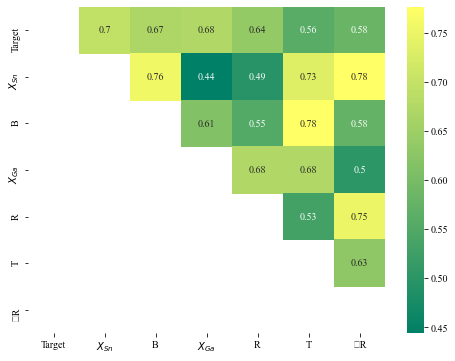

In [11]:
def ShowHeatMap(DataFrame):
    #colormap = plt.cm.RdBu
    #colormap=cmap=plt.get_cmap("PiYG", 7)
    #colormap= sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    #colormap=sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.2, as_cmap = True)
    colormap=plt.get_cmap("summer")
    ylabels = DataFrame.columns.values.tolist()
    #mask = np.triu(np.ones_like(DataFrame,dtype=bool),k=1)
    mask=np.tril(np.ones_like(DataFrame,dtype=bool))
    f, ax = plt.subplots(figsize=(8, 6))
    #ax.set_title('GRA HeatMap')
    sns.heatmap(DataFrame.astype(float),
                cmap=colormap,
                ax=ax,
                annot=True,
                mask=mask,
                yticklabels=ylabels,
                xticklabels=ylabels)
    #让水平轴标签显示在顶部
    #ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    plt.show()


ShowHeatMap(MIC_matrix)

In [ ]:
绘制单行/单列热图

[Text(0.5, 0, 'Target'),
 Text(1.5, 0, '$X_{Sn}$'),
 Text(2.5, 0, 'B'),
 Text(3.5, 0, '$X_{Ga}$'),
 Text(4.5, 0, 'R'),
 Text(5.5, 0, 'T'),
 Text(6.5, 0, '△R')]

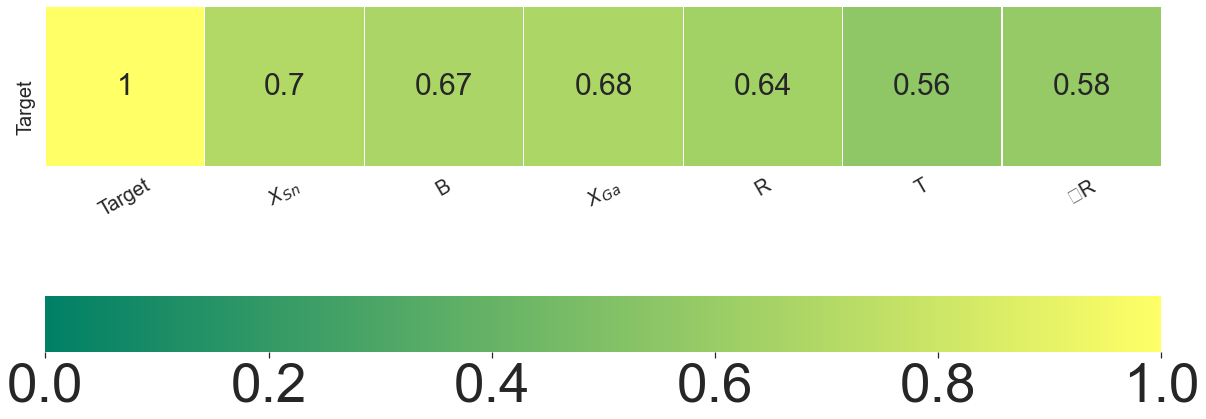

In [29]:
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False   #显示负号
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
plt.figure(figsize=(20, 16))
sns.set(font_scale=5)

#热力图主要参数调整
ax=sns.heatmap(pd.DataFrame(MIC_matrix.iloc[0,:]).T,square=True,
               cbar_kws={'orientation': 'horizontal',"shrink": 1},annot=True,annot_kws={"size": 30},vmax=1.0,vmin=0,cmap='summer',linewidths=0.05,linecolor='white')
#更改坐标轴标签字体大小
ax.tick_params(labelsize=20)
# 旋转x轴刻度上文字方向
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


[Text(0.5, 0, 'Target'),
 Text(1.5, 0, 'f0'),
 Text(2.5, 0, 'f11'),
 Text(3.5, 0, 'f5'),
 Text(4.5, 0, 'f20'),
 Text(5.5, 0, 'f15'),
 Text(6.5, 0, 'f21')]

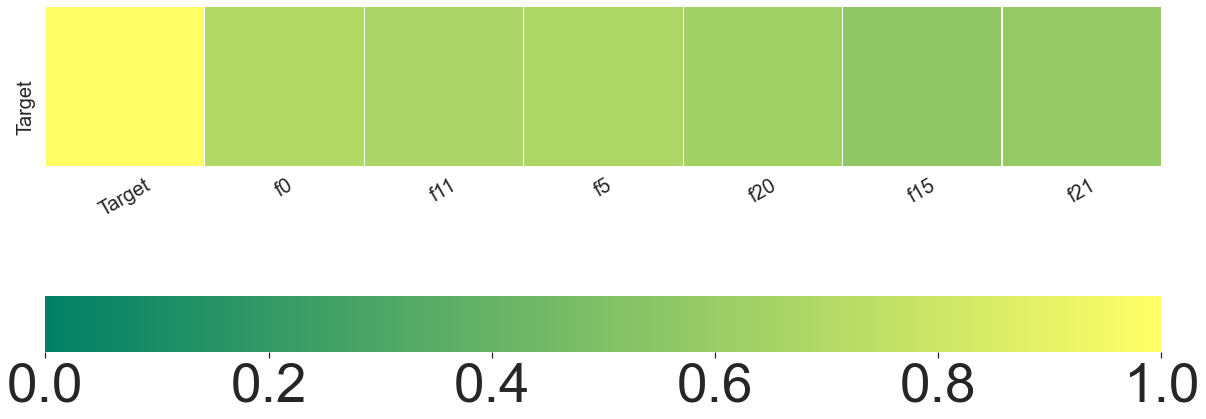

In [19]:
plt.rcParams['font.sans-serif']=['Simhei'] #显示中文
plt.rcParams['axes.unicode_minus']=False   #显示负号
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
plt.figure(figsize=(20, 16))
sns.set(font_scale=5)

#热力图主要参数调整
ax=sns.heatmap(pd.DataFrame(MIC_matrix.iloc[0,:]).T,square=True,
               cbar_kws={'orientation': 'horizontal',"shrink": 1},vmax=1.0,vmin=0,cmap='summer',linewidths=0.05,linecolor='white')
#更改坐标轴标签字体大小
ax.tick_params(labelsize=20)
# 旋转x轴刻度上文字方向
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)